# Coding sections (Skip down to Results Section)

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from pprint import pprint
from IPython.display import display

# Programming shiz

## transform CSV in programmable JSON

In [2]:
teams = {
    "advanced": {},
    "intermediate": {},
    "recreational": {}
}

with open("BKBouldering League 2.0 - Overall Team Scores (as of 2022-03-15).csv") as team_scores_file:
    cat = "advanced"
    for line_num, line in enumerate(team_scores_file.readlines()):
        if line_num < 2:
            continue
        if "intermediate" in line.lower():
            cat = "intermediate"
        elif "recreational" in line.lower():
            cat = "recreational"
        else:
            cells = pd.read_csv(StringIO(line))
            if cells.iloc[0:0, 1].name.strip() == "":
                continue
            team_name = cells.iloc[0:0, 1].name
            climber_1 = cells.iloc[0:0, 5].name
            climber_2 = cells.iloc[0:0, 9].name
            teams[cat][climber_1] = team_name
            teams[cat][climber_2] = team_name

In [3]:
person_scores = {
    "advanced": {},
    "intermediate": {},
    "recreational": {}
}

team_weekly_scores = {
    "advanced": {},
    "intermediate": {},
    "recreational": {}
}

def read_person_weekly_scores(all_person_scores):
    weekly_scores = {}
    starting_positions = range(0, len(all_person_scores), 3)
    for week, i in enumerate(starting_positions):
        raw_scores = all_person_scores[i:i+3]
        weekly_scores[f"week-{len(starting_positions)-week}"] = {
            "tops": int(raw_scores[0].strip()),
            "zones": int(raw_scores[1].strip()),
            "attempts": int(raw_scores[2].strip()),
        }
    return weekly_scores


with open("BKBouldering League 2.0 - Overall Individual Scores (as of 2022-03-15).csv") as indi_scores_file:
    cat = "advanced"
    for line_num, line in enumerate(indi_scores_file.readlines()):
        if line_num < 3:
            continue
        if "intermediate" in line.lower():
            cat = "intermediate"
        elif "recreational" in line.lower():
            cat = "recreational"
        else:
            cells = line.split(",")
            if cells[0].strip() == "":
                continue
            name = cells[1]
            scores = cells[11:]
            person_scores[cat][name] = read_person_weekly_scores(scores)
            if teams[cat][name] not in team_weekly_scores[cat]:
                team_weekly_scores[cat][teams[cat][name]] = {}
            for week in person_scores[cat][name].keys():
                if week not in team_weekly_scores[cat][teams[cat][name]]:
                    team_weekly_scores[cat][teams[cat][name]][week] =  {
                        "tops": 0,
                        "zones": 0,
                        "attempts": 0,
                    }
                team_weekly_scores[cat][teams[cat][name]][week]["tops"] += person_scores[cat][name][week]["tops"]
                team_weekly_scores[cat][teams[cat][name]][week]["zones"] += person_scores[cat][name][week]["zones"]
                team_weekly_scores[cat][teams[cat][name]][week]["attempts"] += person_scores[cat][name][week]["attempts"]

In [4]:
aggregate_scores = {}
aggregate_team_scores = {}
worst_weeks = {}
for cat in person_scores.keys():
    aggregate_scores[cat] = {}
    aggregate_team_scores[cat] = {}
    worst_weeks[cat] = {}
    for person in person_scores[cat].keys():
        aggregate_scores[cat][person] = {
            "overall": {},
            "adjusted": {}
        }
        if teams[cat][person] not in  aggregate_team_scores[cat]:
            aggregate_team_scores[cat][teams[cat][person]] = {
                "overall": {
                    "tops": 0,
                    "zones": 0,
                    "attempts": 0
                },
                "adjusted": {
                    "tops": 0,
                    "zones": 0,
                    "attempts": 0
                }
            }
        weekly_scores = list(person_scores[cat][person].values())
        aggregate_scores[cat][person]["overall"] = {
            "tops": sum(map(lambda s: s["tops"], weekly_scores)),
            "zones": sum(map(lambda s: s["zones"], weekly_scores)),
            "attempts": sum(map(lambda s: s["attempts"], weekly_scores))
        }
        aggregate_team_scores[cat][teams[cat][person]]["overall"]["tops"] += aggregate_scores[cat][person]["overall"]["tops"]
        aggregate_team_scores[cat][teams[cat][person]]["overall"]["zones"] += aggregate_scores[cat][person]["overall"]["zones"]
        aggregate_team_scores[cat][teams[cat][person]]["overall"]["attempts"] += aggregate_scores[cat][person]["overall"]["attempts"]

        sorted_weekly_scores = sorted(
            weekly_scores, 
            reverse=True,
            key=lambda s: (s['tops'], s['zones'], -s['attempts']) # sort by max zones, max tops, min atttemps
        )
        min_week = sorted_weekly_scores[-1]
        worst_weeks[cat][person] = min_week
        aggregate_scores[cat][person]["adjusted"] = {
            "tops": aggregate_scores[cat][person]["overall"]["tops"] - min_week["tops"],
            "zones": aggregate_scores[cat][person]["overall"]["zones"] - min_week["zones"],
            "attempts": aggregate_scores[cat][person]["overall"]["attempts"] - min_week["attempts"],
        }
        aggregate_team_scores[cat][teams[cat][person]]["adjusted"]["tops"] += aggregate_scores[cat][person]["adjusted"]["tops"]
        aggregate_team_scores[cat][teams[cat][person]]["adjusted"]["zones"] += aggregate_scores[cat][person]["adjusted"]["zones"]
        aggregate_team_scores[cat][teams[cat][person]]["adjusted"]["attempts"] += aggregate_scores[cat][person]["adjusted"]["attempts"]

In [5]:
def prepare_results(catgeory, score_type):
    scores = []
    for person in aggregate_scores[catgeory].keys():
        score = aggregate_scores[catgeory][person][score_type].copy()
        score["name"] = person
        score["worst_week"] = json.dumps(worst_weeks[catgeory][person])
        scores.append(score)
    scores_df = pd.DataFrame.from_dict(scores).set_index("name")
    # sorting
    scores_df["attempts"] = -scores_df["attempts"]
    scores_df = scores_df.sort_values(by=['tops', 'zones', 'attempts'], ascending=False)
    scores_df["attempts"] = -scores_df["attempts"]
    scores_df['rank'] = range(len(scores_df))
    scores_df['rank'] += 1 
    scores_df = scores_df.reindex(columns=['rank', 'tops', 'zones', 'attempts', 'worst_week'])
    return scores_df


def prepare_team_results(catgeory, score_type):
    scores = []
    for team in aggregate_team_scores[catgeory].keys():
        score = aggregate_team_scores[catgeory][team][score_type].copy()
        score["name"] = team
        scores.append(score)
    scores_df = pd.DataFrame.from_dict(scores).set_index("name")
    # sorting
    scores_df["attempts"] = -scores_df["attempts"]
    scores_df = scores_df.sort_values(by=['tops', 'zones', 'attempts'], ascending=False)
    scores_df["attempts"] = -scores_df["attempts"]
    scores_df['rank'] = range(len(scores_df))
    scores_df['rank'] += 1 
    scores_df = scores_df.reindex(columns=['rank', 'tops', 'zones', 'attempts'])
    return scores_df


def plot_results(ranked_dataframe, title, height=18):
    g = sns.catplot(
        data=ranked_dataframe.melt(ignore_index=False, var_name='cols', value_name='vals').reset_index(), 
        kind="bar",
        x="vals", 
        y="name", 
        hue="cols",
        height=height,
        aspect=1.5
    )
    g.set(title=title)
    g.set_axis_labels("Count", "Rankings")
    g.legend.set_title("Legend")

    # extract the matplotlib axes_subplot objects from the FacetGrid
    ax = g.facet_axis(0, 0)

    # iterate through the axes containers
    for c in ax.containers:
        labels = [f'{(v.get_width()):.0f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')

In [6]:
def weekly_ranks_cummulative(catgeory):
    # pivote the data to be by week
    weekly_person_scores = {}
    for person in person_scores[catgeory].keys():
        score_so_far = {
            "tops": 0,
            "zones": 0,
            "attempts": 0,
        }
        for week in sorted(person_scores[catgeory][person].keys()):
            if week not in weekly_person_scores:
                weekly_person_scores[week] = []
            score_so_far["tops"] += person_scores[catgeory][person][week]["tops"]
            score_so_far["zones"] += person_scores[catgeory][person][week]["zones"]
            score_so_far["attempts"] += person_scores[catgeory][person][week]["attempts"]
            item = {
                "name": person,
                "tops": score_so_far["tops"],
                "zones": score_so_far["zones"],
                "attempts": score_so_far["attempts"],
            }
            weekly_person_scores[week].append(item)
    person_ranks={}
    for week in weekly_person_scores.keys():
        sorted_week_scores = sorted(
            weekly_person_scores[week], 
            reverse=True,
            key=lambda s: (s['tops'], s['zones'], -s['attempts'])
        )
        for rank, item in enumerate(sorted_week_scores):
            if item["name"] not in person_ranks:
                person_ranks[item["name"]] = []
            person_ranks[item["name"]].append(rank+1)
    return person_ranks


def team_weekly_ranks_cummulative(catgeory):
    # pivote the data to be by week
    weekly_team_scores = {}
    for team in team_weekly_scores[catgeory].keys():
        score_so_far = {
            "tops": 0,
            "zones": 0,
            "attempts": 0,
        }
        for week in sorted(team_weekly_scores[catgeory][team].keys()):
            if week not in weekly_team_scores:
                weekly_team_scores[week] = []
            score_so_far["tops"] += team_weekly_scores[catgeory][team][week]["tops"]
            score_so_far["zones"] += team_weekly_scores[catgeory][team][week]["zones"]
            score_so_far["attempts"] += team_weekly_scores[catgeory][team][week]["attempts"]
            item = {
                "name": team,
                "tops": score_so_far["tops"],
                "zones": score_so_far["zones"],
                "attempts": score_so_far["attempts"],
            }
            weekly_team_scores[week].append(item)
    team_ranks={}
    for week in weekly_team_scores.keys():
        sorted_week_scores = sorted(
            weekly_team_scores[week], 
            reverse=True,
            key=lambda s: (s['tops'], s['zones'], -s['attempts'])
        )
        for rank, item in enumerate(sorted_week_scores):
            if "oreo" in item["name"].lower():
                print(week, item)
            if item["name"] not in team_ranks:
                team_ranks[item["name"]] = []
            team_ranks[item["name"]].append(rank+1)
    return team_ranks


def plot_rank_progression(weekly_ranks, title):
    # let's figure out the starting and ending ranks first
    starting_ranks = list(map(lambda name: (f"{name}({weekly_ranks[name][0]})", weekly_ranks[name][0]), weekly_ranks.keys()))
    starting_tick_labels=[]
    starting_ticks=[]
    for rank in starting_ranks:
        starting_tick_labels.append(rank[0])
        starting_ticks.append(rank[1])
    ending_ranks = list(map(lambda name: (f"{name}({weekly_ranks[name][-1]})", weekly_ranks[name][-1]), weekly_ranks.keys()))
    ending_tick_labels=[]
    ending_ticks=[]
    for rank in ending_ranks:
        ending_tick_labels.append(rank[0])
        ending_ticks.append(rank[1])

    num_weeks = np.max(list(map(lambda x: len(x), weekly_ranks.values())))

    # now lets setup some basic labelling for readability
    fig, ax1 = plt.subplots(figsize=(num_weeks*2, len(weekly_ranks.keys())))

    plt.title(title)
    plt.grid(True, linestyle='--')
    
    ax2 = ax1.twinx()
    ax1.invert_yaxis()
    ax2.invert_yaxis()

    ax1.set_xlabel("Weeks")

    ax1.set_ylabel("Starting Rank")
    ax1.set_yticks(starting_ticks, labels=starting_tick_labels)
    ax2.set_ylabel("Ending Rank")
    ax2.set_yticks(ending_ticks, labels=ending_tick_labels)

    x_ticks = range(int(num_weeks))
    x_labels = list(map(lambda n: f"week-{n+1}", x_ticks))
    ax1.set_xticks(x_ticks, labels=x_labels)
    for person in weekly_ranks.keys():
        ax1.plot(weekly_ranks[person], marker="o", mfc="w", markersize=10)
        ax2.plot(weekly_ranks[person], marker="o", mfc="w", markersize=10)

# Results

## Aggregate Results

### Team Results: Advanced

,rank,tops,zones,attempts
name,,,,
Crimpin' Ain't Easy,1,30,46,156
Biggie Smalls,2,30,43,118
"Head, Boulders, Knees, & Toes",3,29,46,84
Mikko Chi,4,25,40,67
Zander & Jaymz,5,18,27,45
A Mao A Go Climbing Stando,6,14,22,50
Los Conejitos Malos,7,10,16,37


,rank,tops,zones,attempts
name,,,,
Biggie Smalls,1,23,29,99
Crimpin' Ain't Easy,2,22,32,137
"Head, Boulders, Knees, & Toes",3,20,31,53
Zander & Jaymz,4,18,27,45
Mikko Chi,5,18,27,52
A Mao A Go Climbing Stando,6,11,15,43
Los Conejitos Malos,7,10,16,37


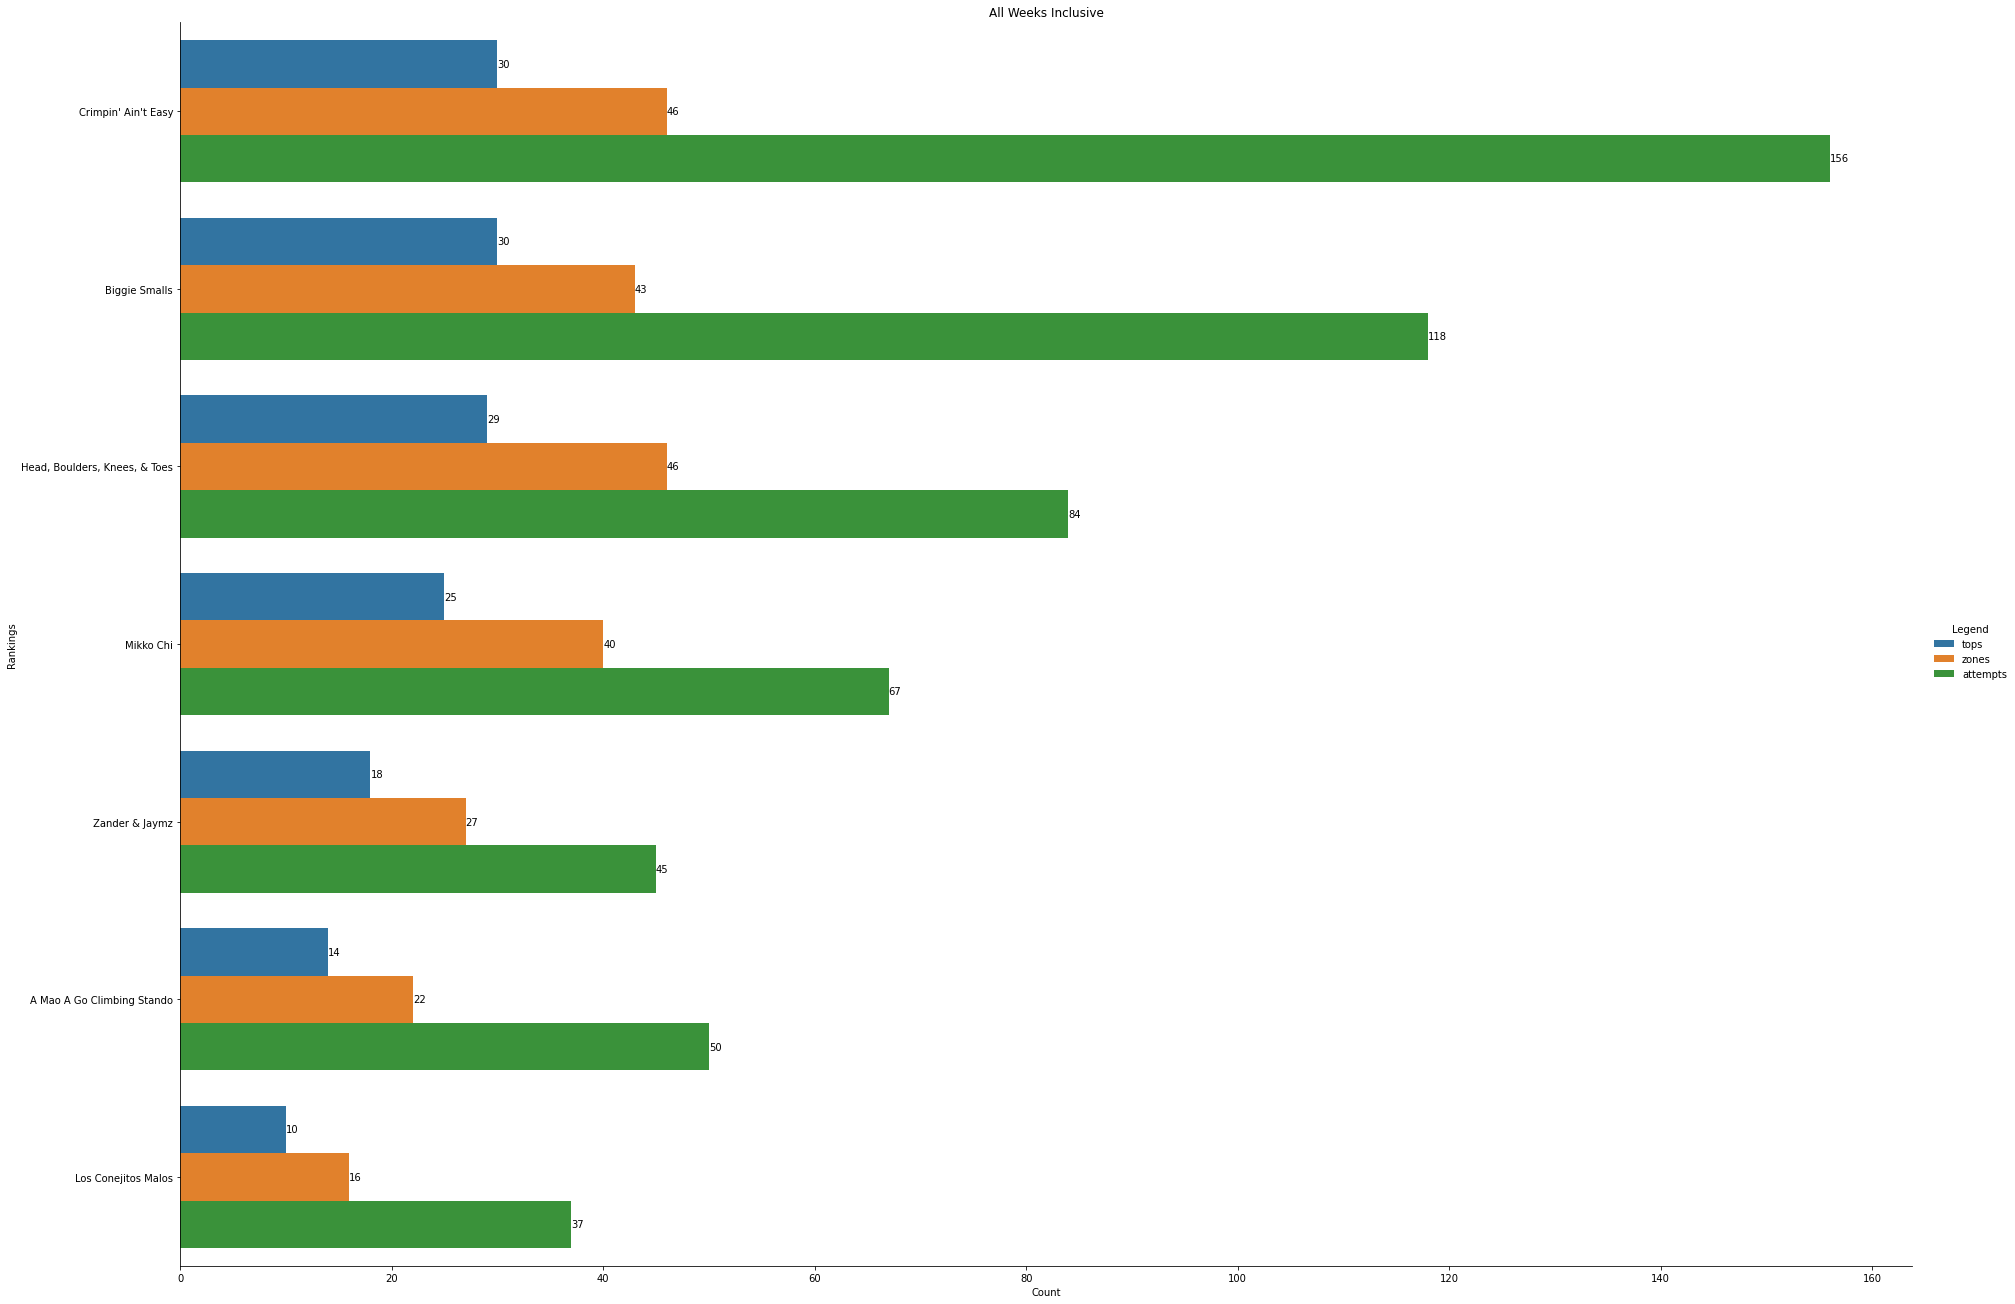

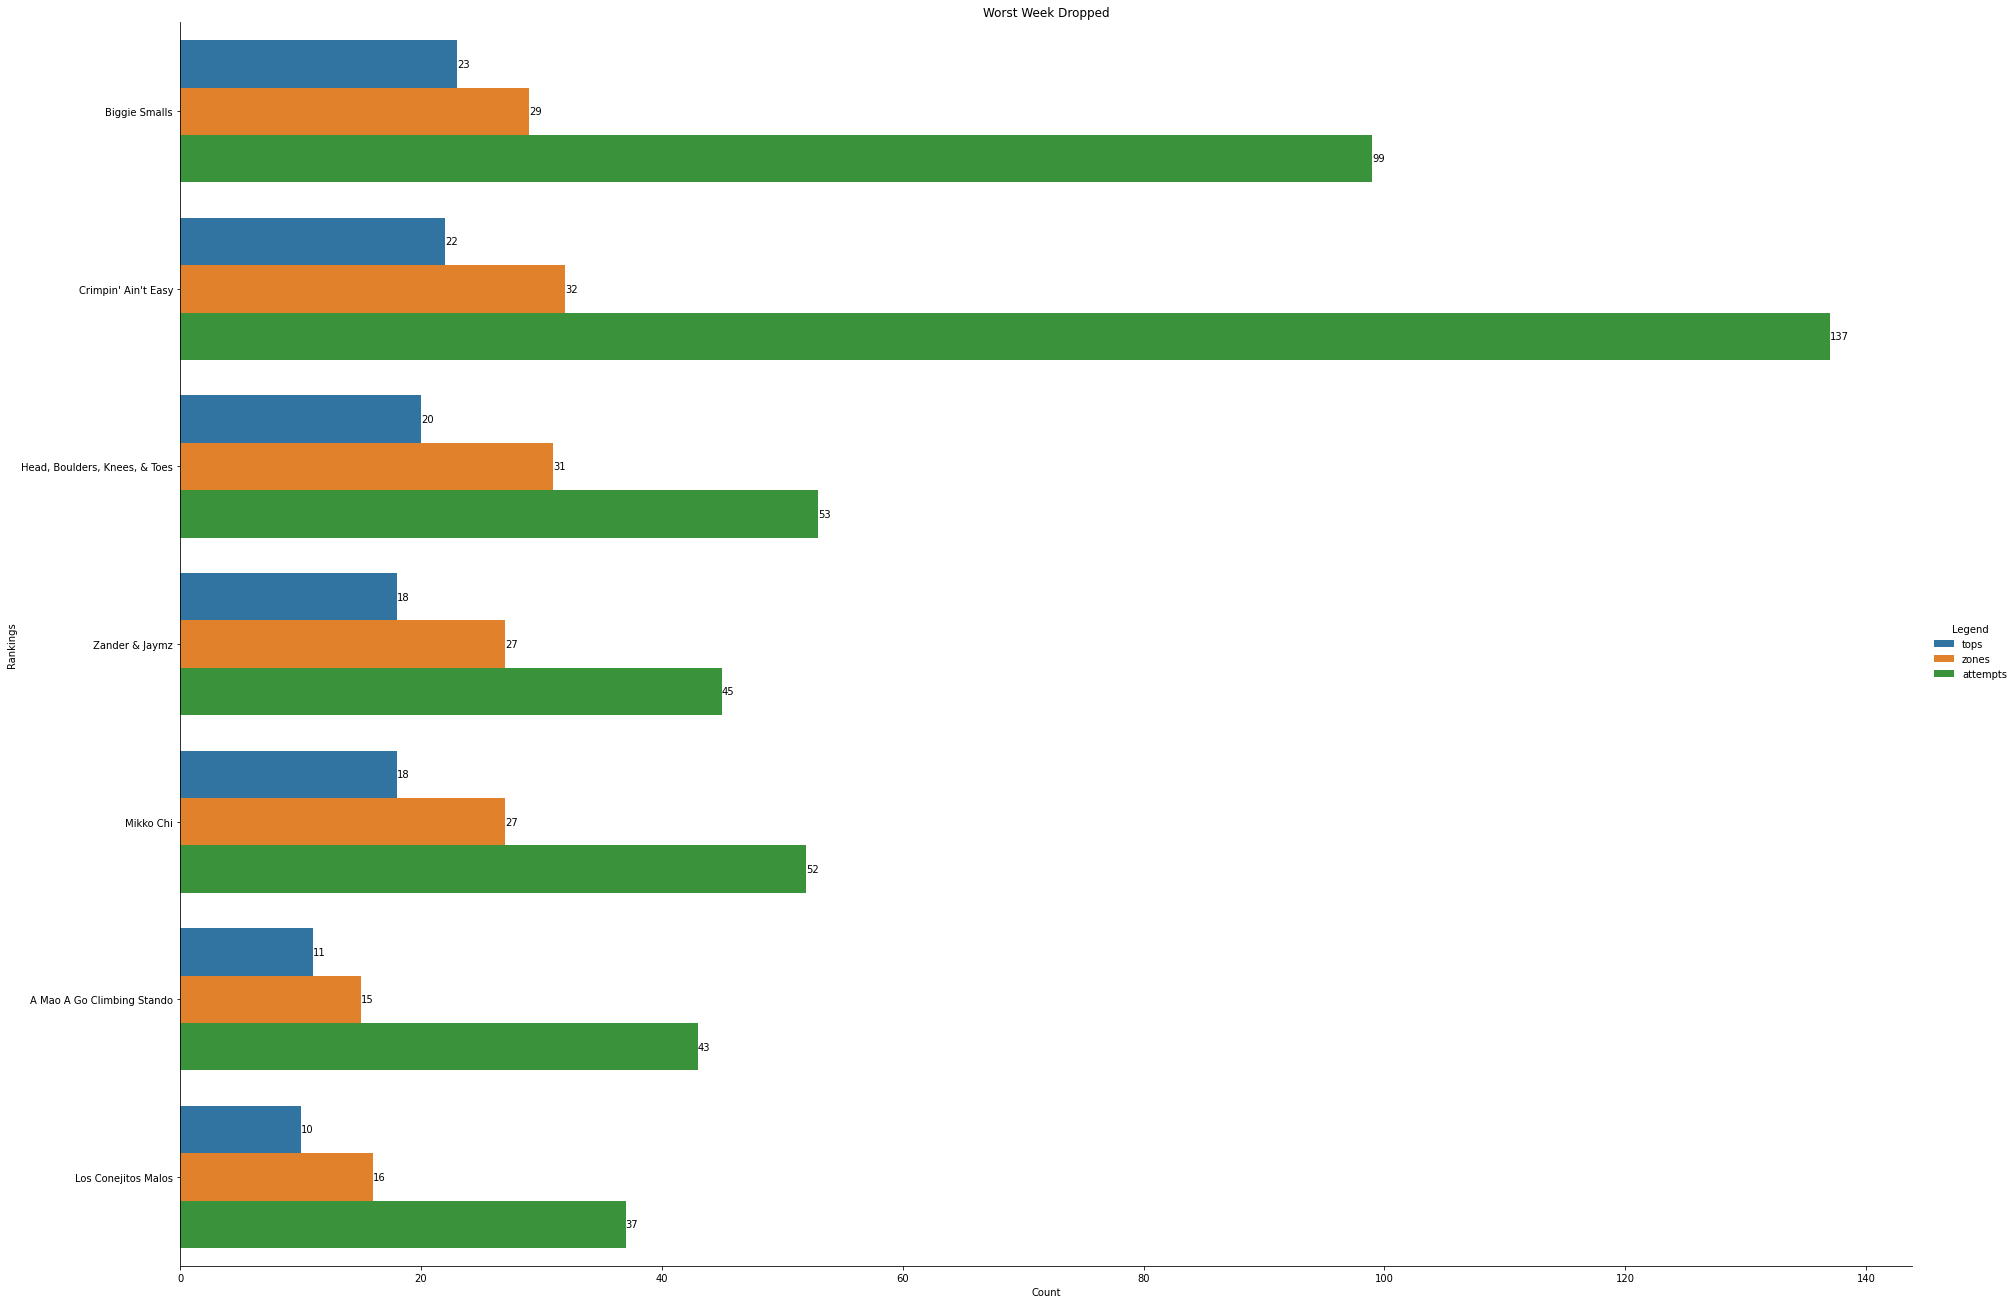

In [7]:
advanced_team_results_overall = prepare_team_results("advanced", "overall")
advanced_team_results_adjusted = prepare_team_results("advanced", "adjusted")

display(advanced_team_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(advanced_team_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

advanced_team_results_overall = advanced_team_results_overall.drop(["rank"], axis=1)
advanced_team_results_adjusted = advanced_team_results_adjusted.drop(["rank"], axis=1)

plot_results(advanced_team_results_overall, "All Weeks Inclusive")
plot_results(advanced_team_results_adjusted, "Worst Week Dropped")

### Individuals Results: Advanced

,rank,tops,zones,attempts,worst_week
name,,,,,
Dominick Magnotta,1,20,26,50,"{""tops"": 6, ""zones"": 9, ""attempts"": 15}"
Steve Chi,2,16,25,39,"{""tops"": 4, ""zones"": 9, ""attempts"": 6}"
Mark Bungeroth,3,16,25,112,"{""tops"": 4, ""zones"": 8, ""attempts"": 12}"
Robert Tom,4,16,24,56,"{""tops"": 5, ""zones"": 8, ""attempts"": 16}"
Catalin Milos,5,14,21,44,"{""tops"": 4, ""zones"": 6, ""attempts"": 7}"
Zander,6,14,17,34,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"
Nelson Lim,7,13,22,28,"{""tops"": 4, ""zones"": 7, ""attempts"": 15}"
Junrui Wang,8,12,14,45,"{""tops"": 3, ""zones"": 5, ""attempts"": 7}"
Michael Hill,9,10,17,68,"{""tops"": 1, ""zones"": 5, ""attempts"": 4}"


,rank,tops,zones,attempts,worst_week
name,,,,,
Zander,1,14,17,34,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"
Dominick Magnotta,2,14,17,35,"{""tops"": 6, ""zones"": 9, ""attempts"": 15}"
Mark Bungeroth,3,12,17,100,"{""tops"": 4, ""zones"": 8, ""attempts"": 12}"
Steve Chi,4,12,16,33,"{""tops"": 4, ""zones"": 9, ""attempts"": 6}"
Robert Tom,5,11,16,40,"{""tops"": 5, ""zones"": 8, ""attempts"": 16}"
Carlos Cuenca,6,10,16,37,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"
Catalin Milos,7,10,15,37,"{""tops"": 4, ""zones"": 6, ""attempts"": 7}"
Nelson Lim,8,9,15,13,"{""tops"": 4, ""zones"": 7, ""attempts"": 15}"
Michael Hill,9,9,12,64,"{""tops"": 1, ""zones"": 5, ""attempts"": 4}"


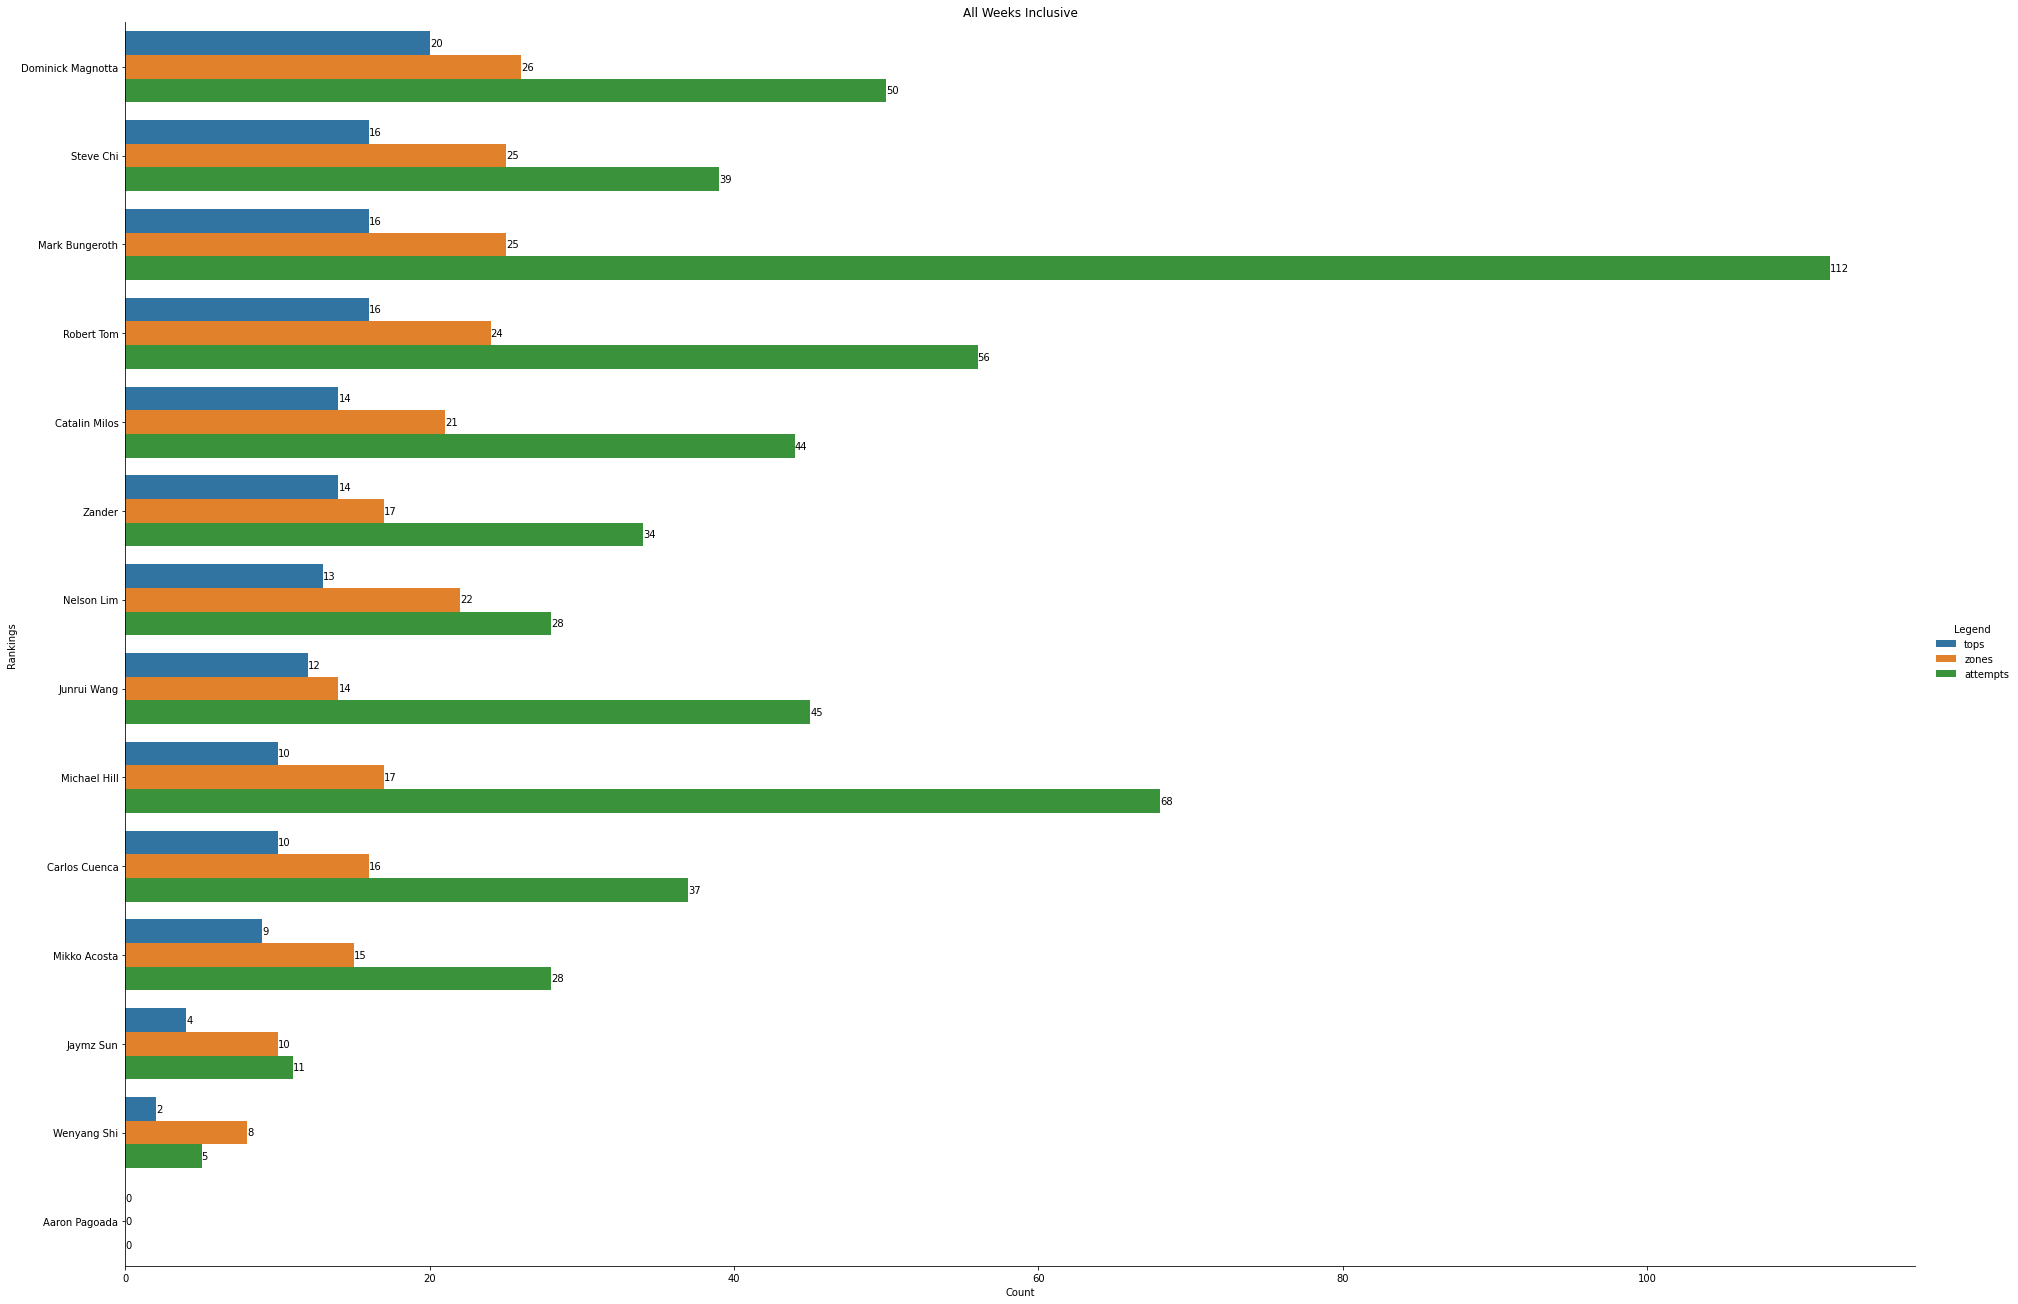

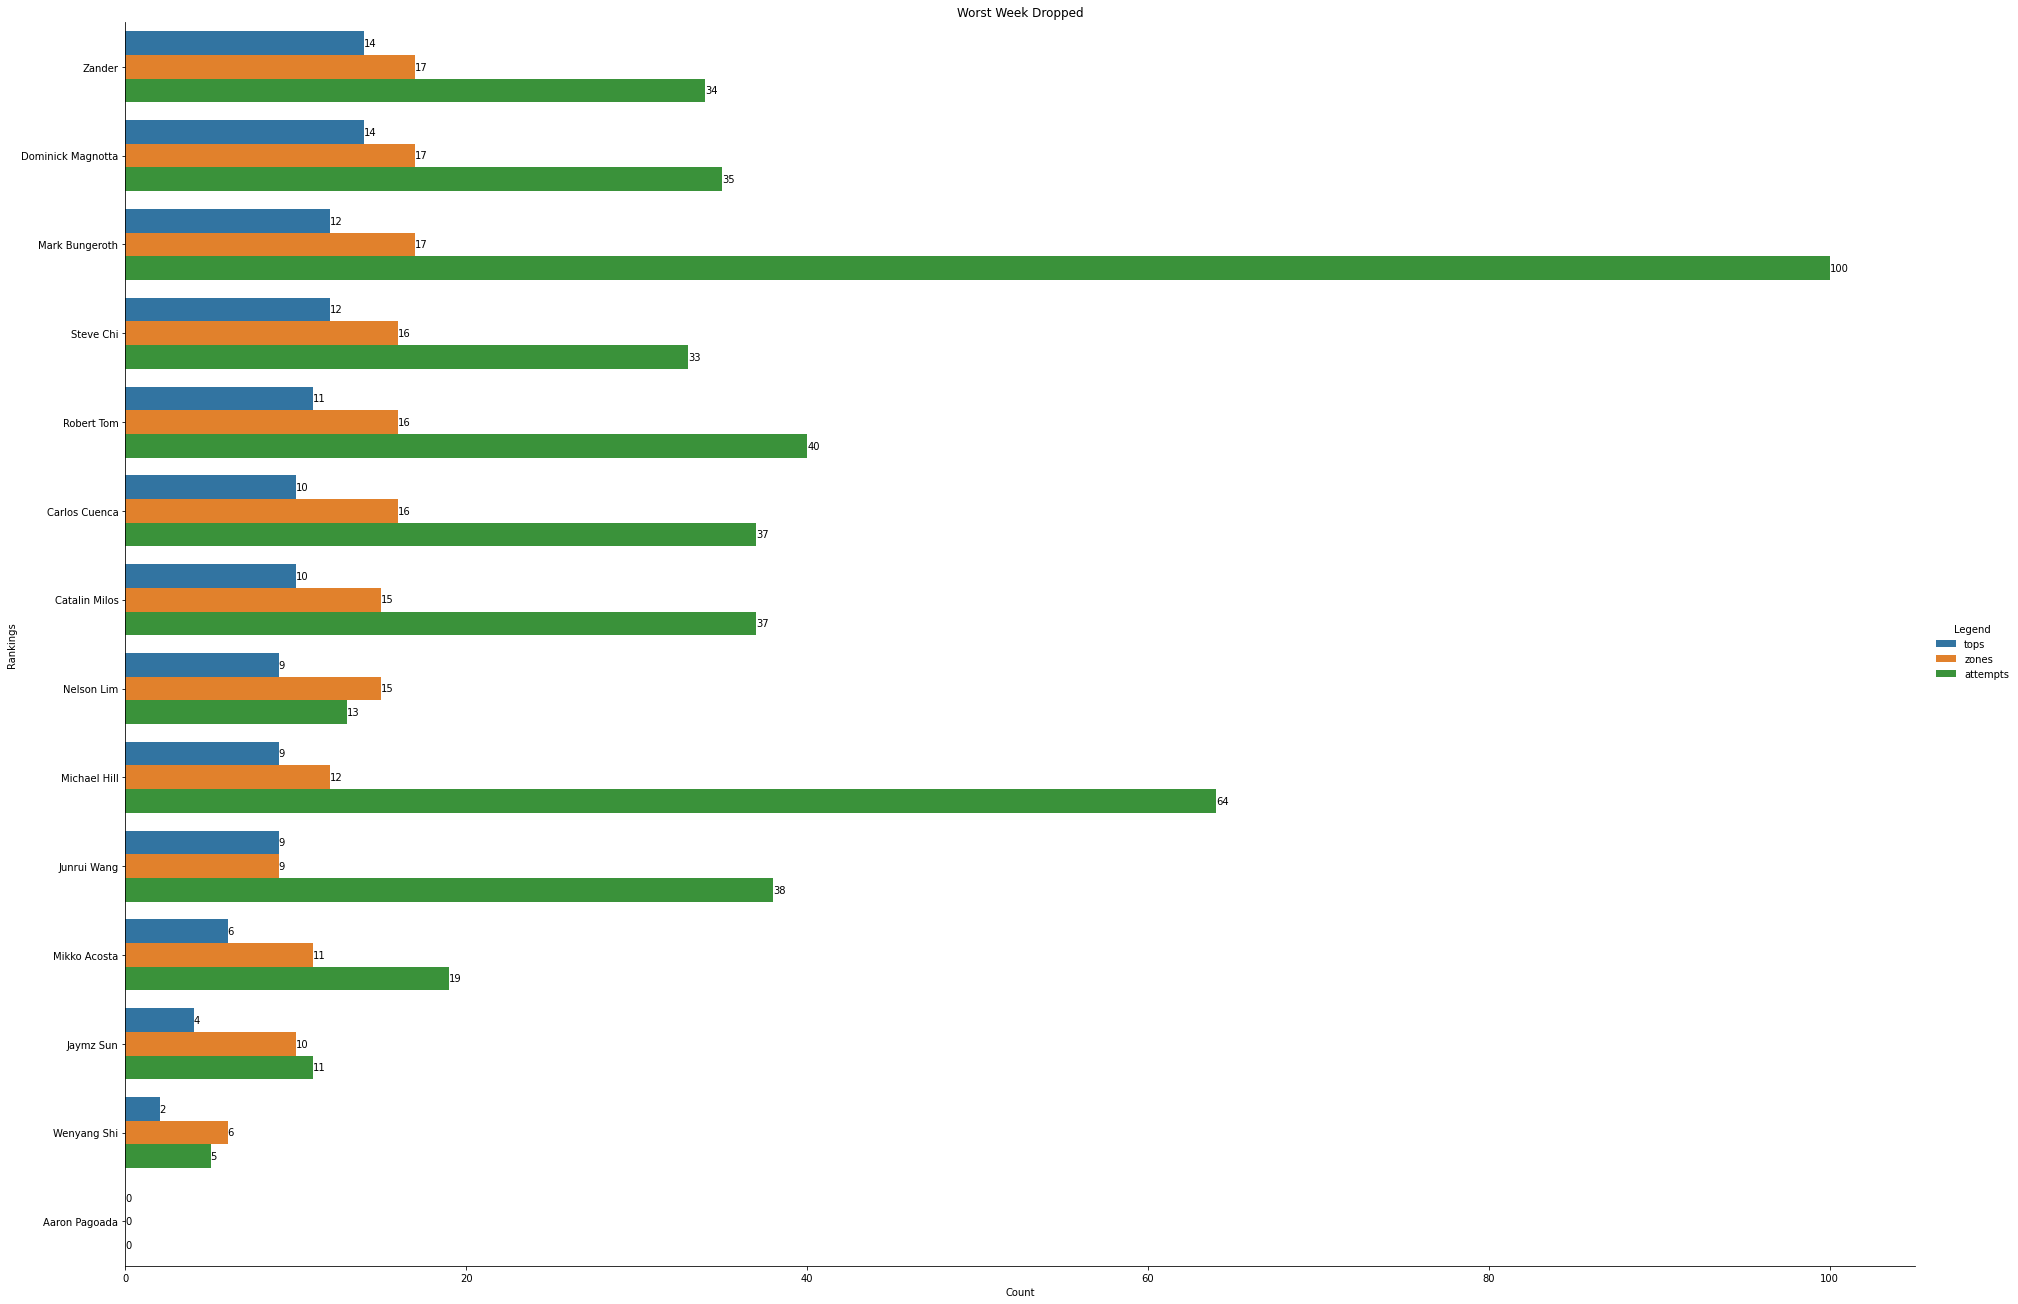

In [8]:
advanced_results_overall = prepare_results("advanced", "overall")
advanced_results_adjusted = prepare_results("advanced", "adjusted")

display(advanced_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(advanced_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

advanced_results_overall = advanced_results_overall.drop(["rank", "worst_week"], axis=1)
advanced_results_adjusted = advanced_results_adjusted.drop(["rank", "worst_week"], axis=1)

plot_results(advanced_results_overall, "All Weeks Inclusive")
plot_results(advanced_results_adjusted, "Worst Week Dropped")


### Team Results: Intermediate

,rank,tops,zones,attempts
name,,,,
Zack & Alex,1,46,57,102
Boulder N Stuff,2,46,53,80
Sweaty Crach,3,43,55,68
Ninja Gaijins,4,39,52,60
Team Oreo,5,39,52,65
Crack Hands,6,39,51,87
Static Flash,7,38,49,56
Golfers Elbow,8,37,50,60
Just Hold On And Go Up,9,37,47,67


,rank,tops,zones,attempts
name,,,,
Zack & Alex,1,33,39,87
Boulder N Stuff,2,32,36,62
Sweaty Crach,3,29,37,35
Team Oreo,4,28,35,54
The Prokaryotes,5,28,34,39
Ninja Gaijins,6,28,34,42
Crack Hands,7,28,34,64
Static Flash,8,28,32,40
Feary Shorties,9,27,36,44


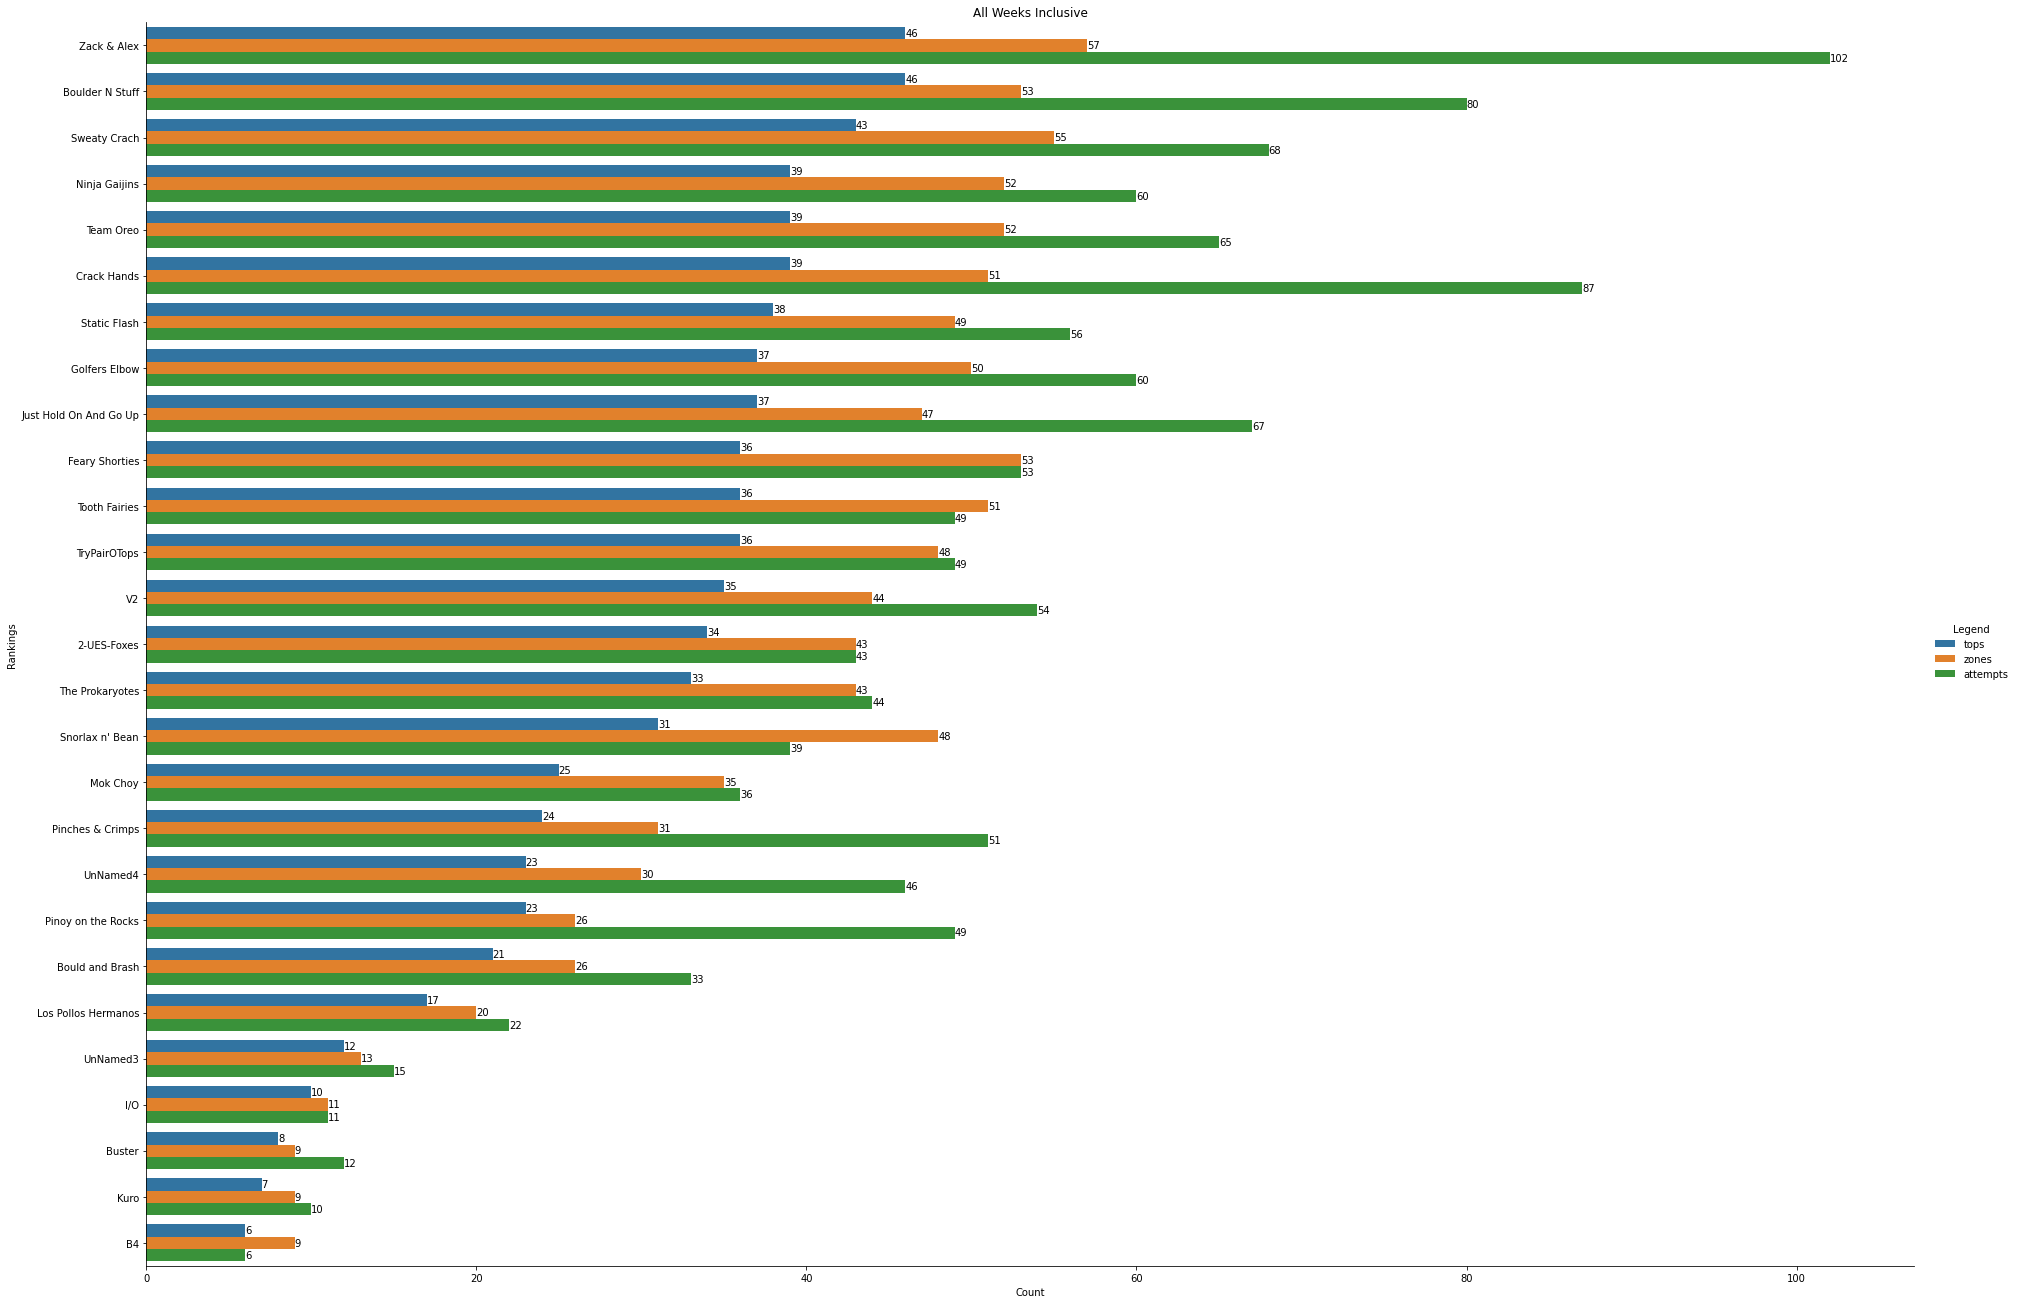

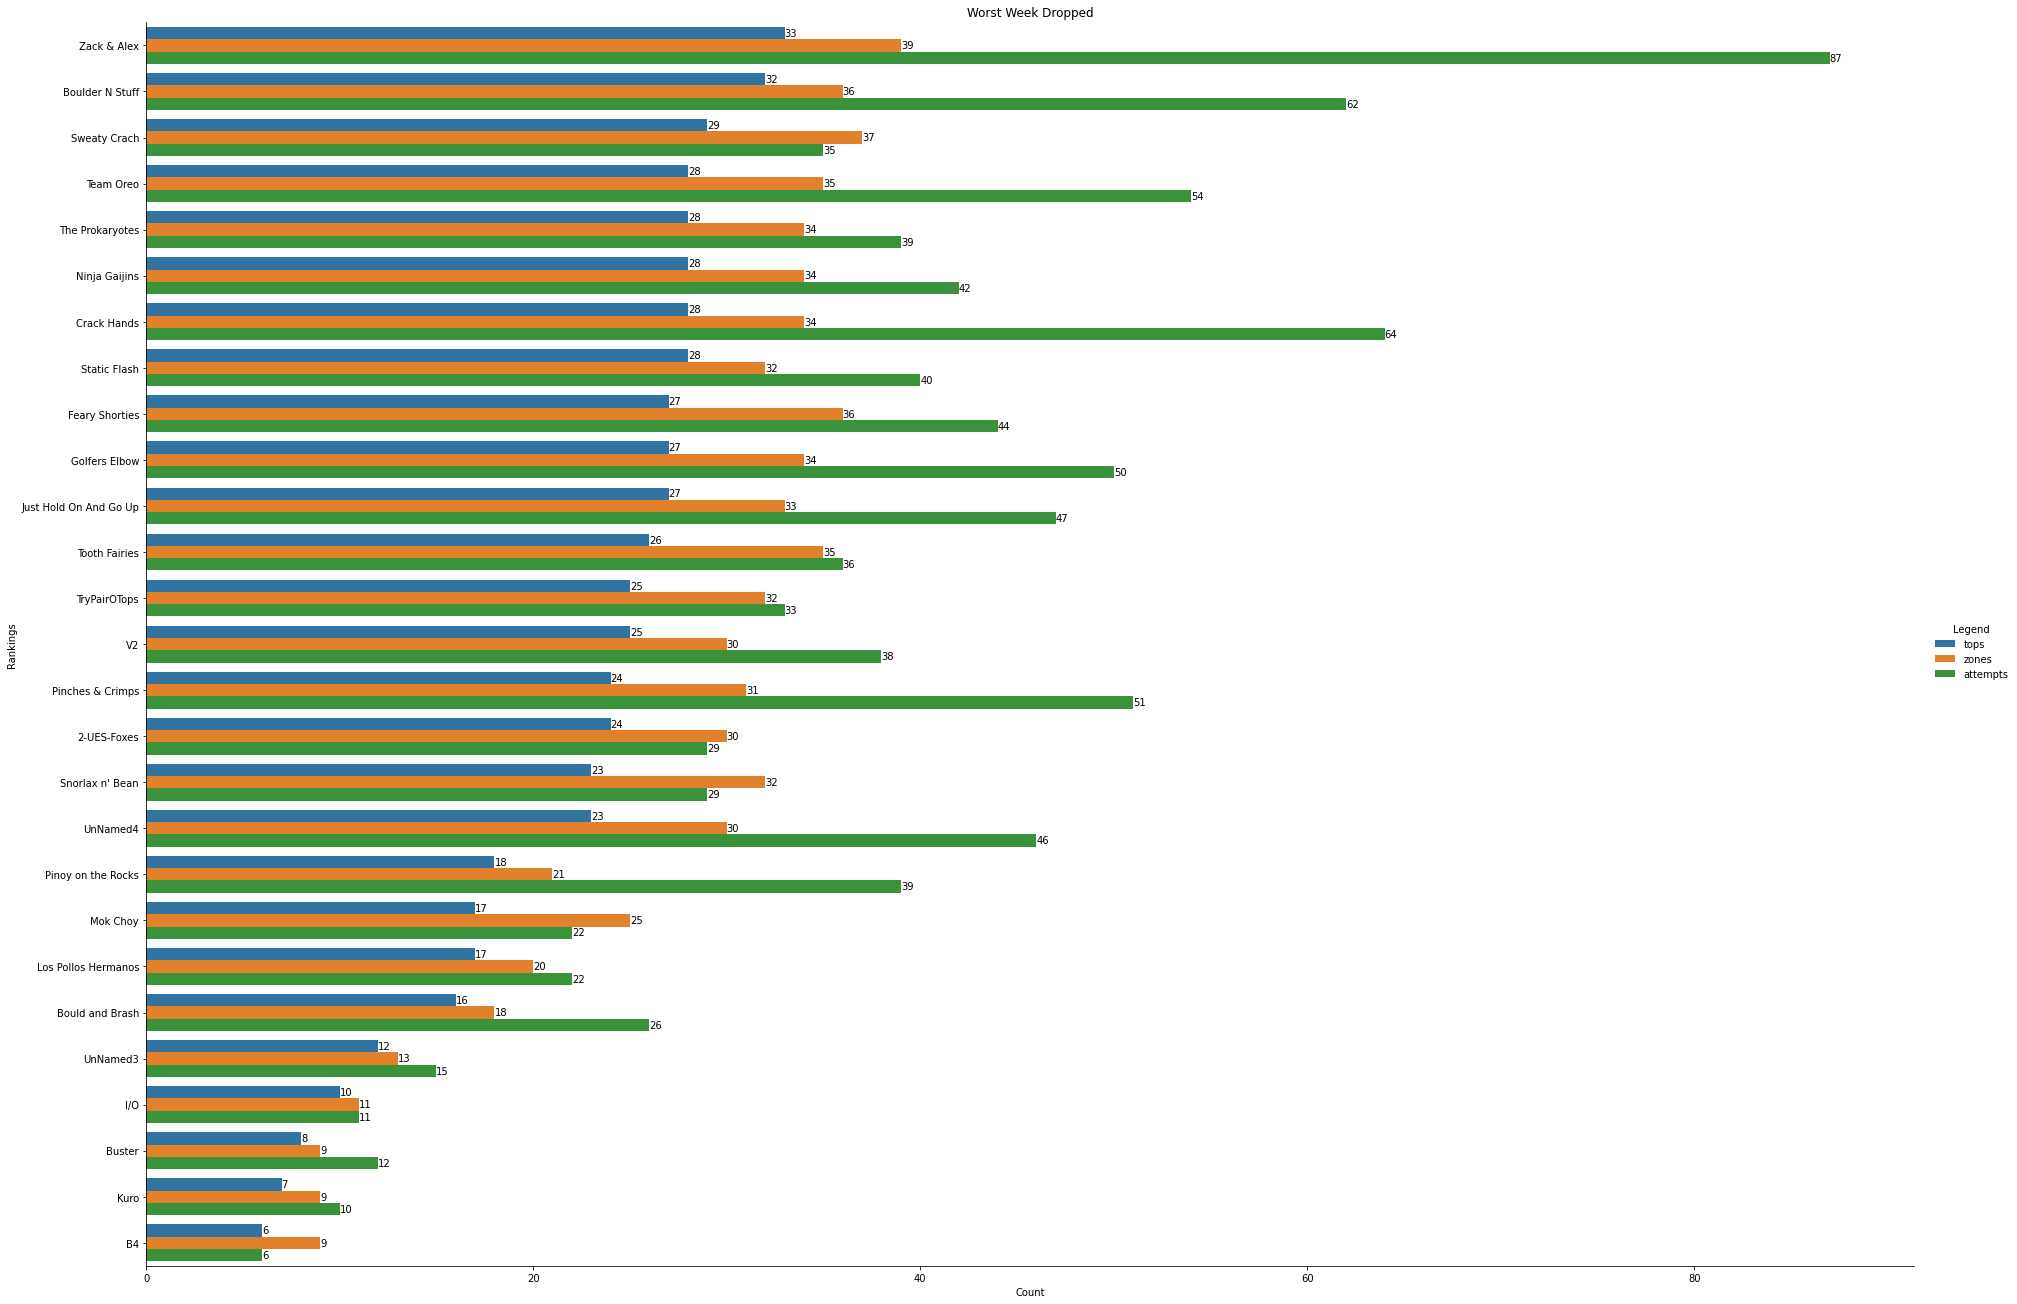

In [9]:
intermediate_team_results_overall = prepare_team_results("intermediate", "overall")
intermediate_team_results_adjusted = prepare_team_results("intermediate", "adjusted")

display(intermediate_team_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(intermediate_team_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

intermediate_team_results_overall = intermediate_team_results_overall.drop(["rank"], axis=1)
intermediate_team_results_adjusted = intermediate_team_results_adjusted.drop(["rank"], axis=1)

plot_results(intermediate_team_results_overall, "All Weeks Inclusive")
plot_results(intermediate_team_results_adjusted, "Worst Week Dropped")

### Individual Results: Intermediate

,rank,tops,zones,attempts,worst_week
name,,,,,
Zach Hyer,1,26,29,81,"{""tops"": 7, ""zones"": 9, ""attempts"": 8}"
Charles Liou,2,25,28,42,"{""tops"": 8, ""zones"": 9, ""attempts"": 10}"
James Rudy,3,23,27,40,"{""tops"": 7, ""zones"": 9, ""attempts"": 14}"
Diego Medina,4,22,30,31,"{""tops"": 7, ""zones"": 10, ""attempts"": 13}"
Daniel Chin,5,22,28,49,"{""tops"": 6, ""zones"": 9, ""attempts"": 10}"
John Eun,6,22,27,30,"{""tops"": 6, ""zones"": 9, ""attempts"": 11}"
Alex Abayev,7,21,28,40,"{""tops"": 6, ""zones"": 9, ""attempts"": 16}"
Alec Gazda,8,21,27,28,"{""tops"": 6, ""zones"": 9, ""attempts"": 6}"
Spencer Carver,9,21,25,31,"{""tops"": 7, ""zones"": 8, ""attempts"": 12}"


,rank,tops,zones,attempts,worst_week
name,,,,,
Zach Hyer,1,19,20,73,"{""tops"": 7, ""zones"": 9, ""attempts"": 8}"
Charles Liou,2,17,19,32,"{""tops"": 8, ""zones"": 9, ""attempts"": 10}"
Chris Carmichael,3,16,19,34,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"
Daniel Chin,4,16,19,39,"{""tops"": 6, ""zones"": 9, ""attempts"": 10}"
John Eun,5,16,18,19,"{""tops"": 6, ""zones"": 9, ""attempts"": 11}"
James Rudy,6,16,18,26,"{""tops"": 7, ""zones"": 9, ""attempts"": 14}"
Diego Medina,7,15,20,18,"{""tops"": 7, ""zones"": 10, ""attempts"": 13}"
Alex Abayev,8,15,19,24,"{""tops"": 6, ""zones"": 9, ""attempts"": 16}"
Colin Konishi,9,15,18,19,"{""tops"": 5, ""zones"": 9, ""attempts"": 5}"


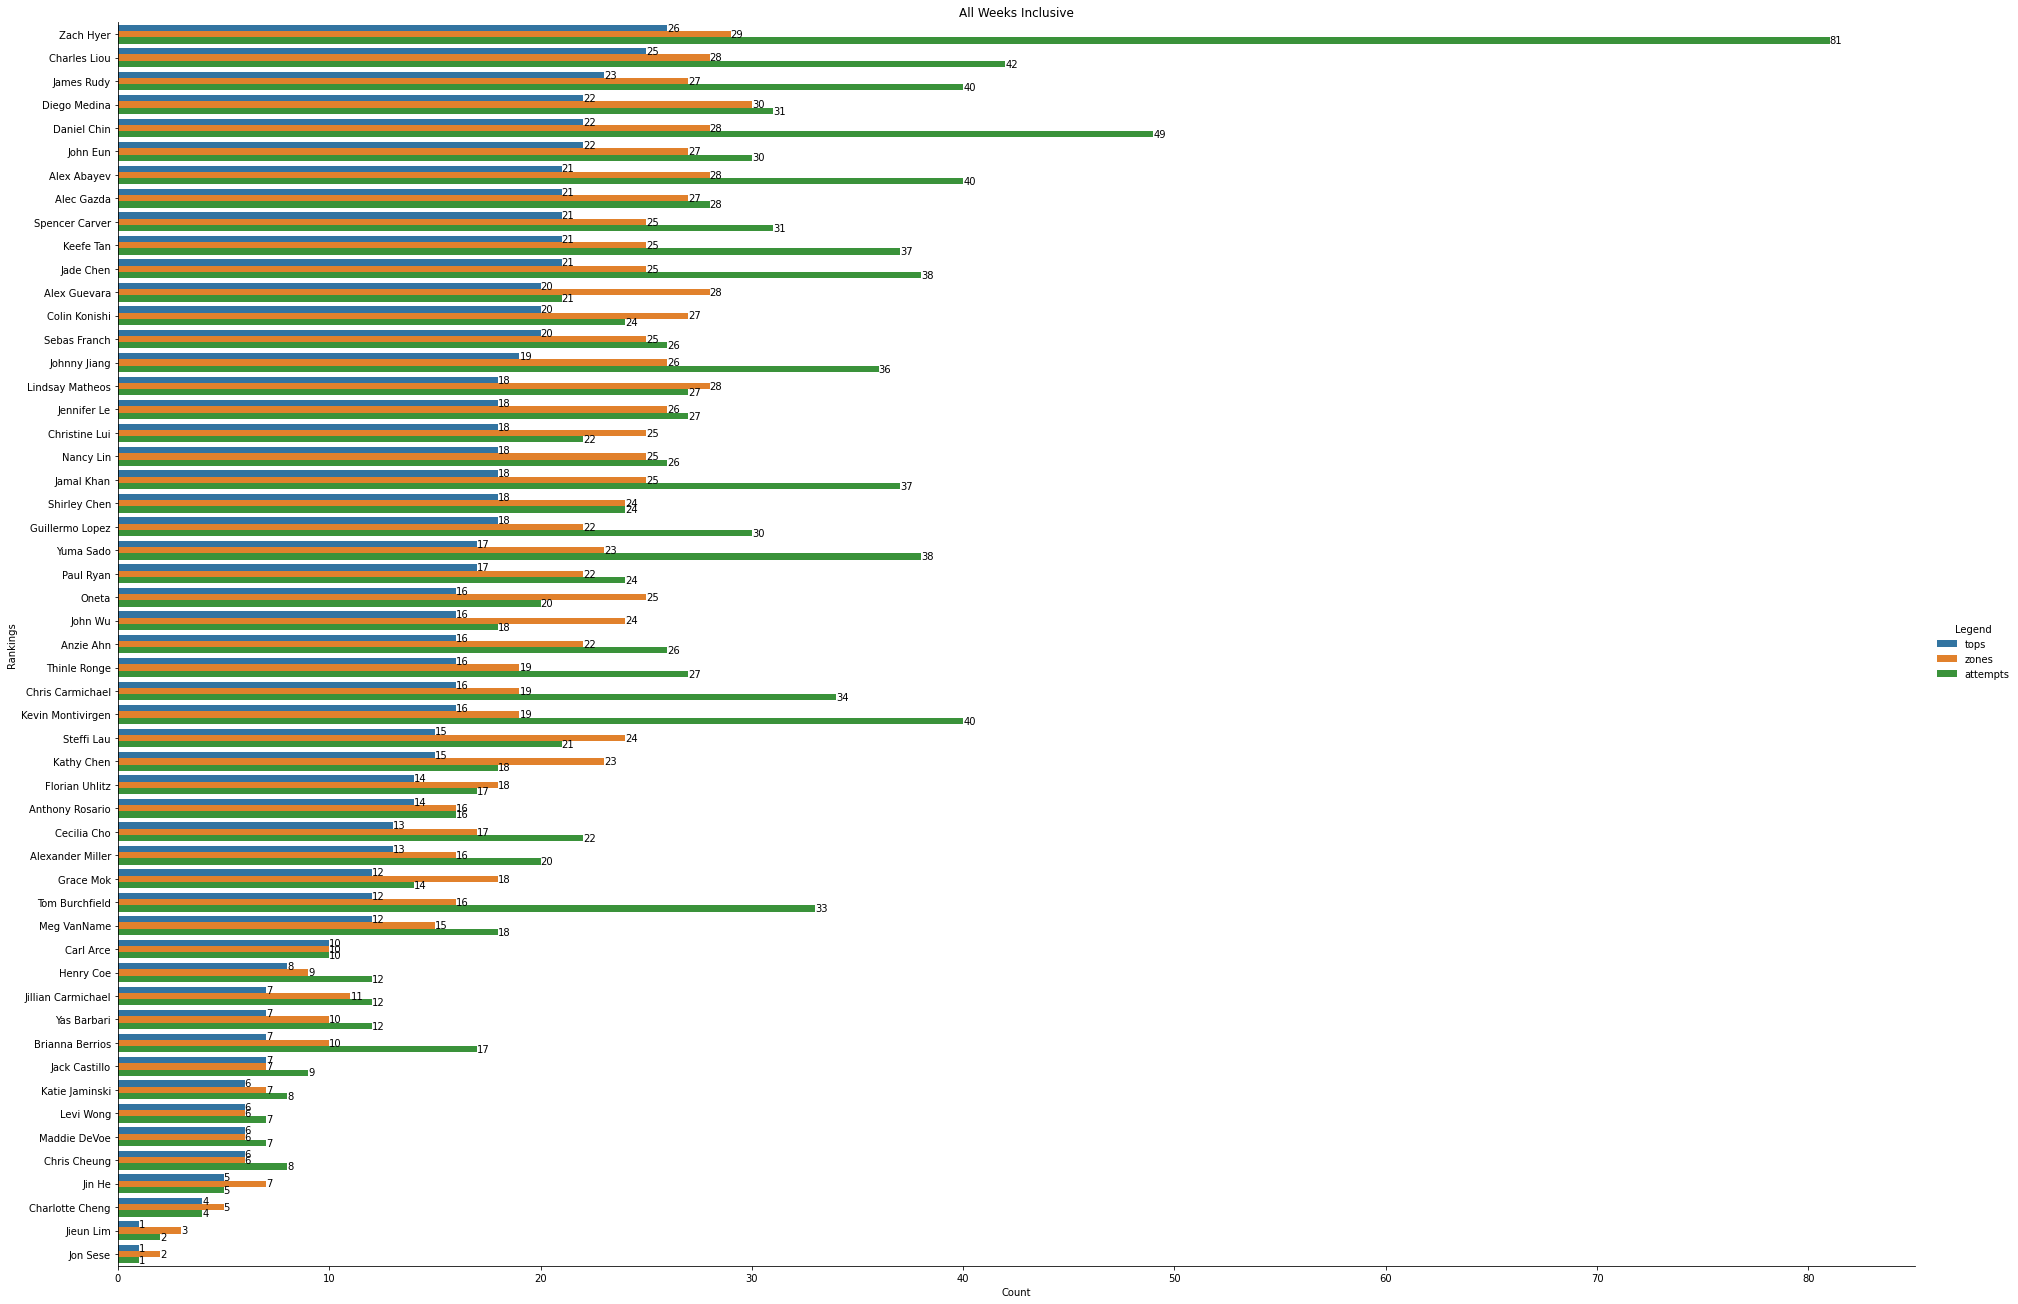

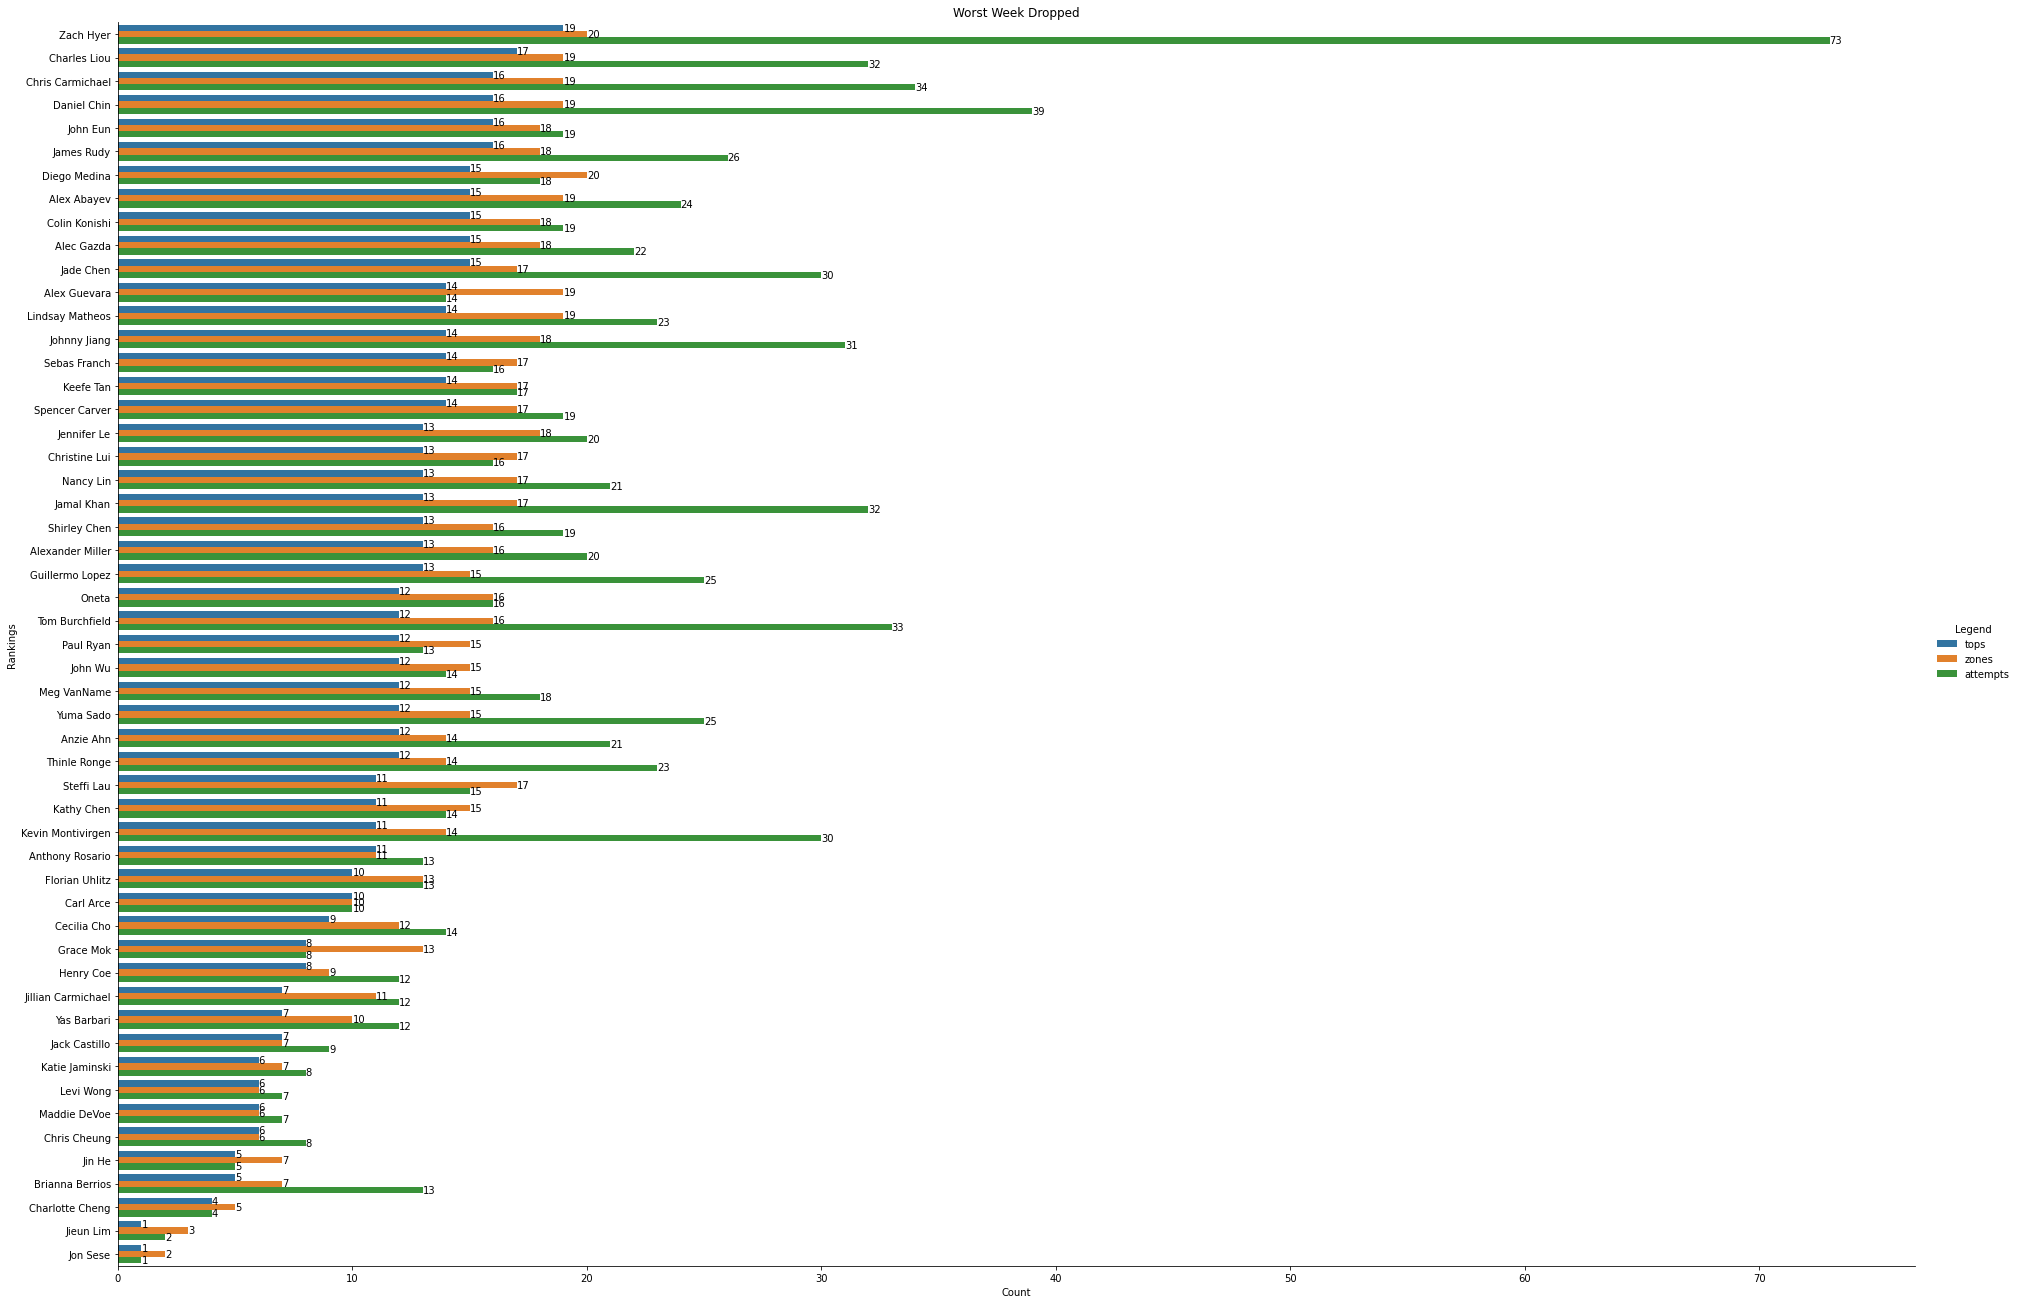

In [10]:
intermediate_results_overall = prepare_results("intermediate", "overall")
intermediate_results_adjusted = prepare_results("intermediate", "adjusted")

display(intermediate_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(intermediate_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

intermediate_results_overall = intermediate_results_overall.drop(["rank", "worst_week"], axis=1)
intermediate_results_adjusted = intermediate_results_adjusted.drop(["rank", "worst_week"], axis=1)

plot_results(intermediate_results_overall, "All Weeks Inclusive")
plot_results(intermediate_results_adjusted, "Worst Week Dropped")

### Team Results: Recreational

,rank,tops,zones,attempts
name,,,,
Chickens Are Cool,1,21,26,60
Queens of Queens,2,19,27,21
Double-A Girlz,3,18,24,20
What's Going On,4,14,23,24
I Pivelli,5,8,12,9


,rank,tops,zones,attempts
name,,,,
Chickens Are Cool,1,15,17,24
Queens of Queens,2,14,19,15
Double-A Girlz,3,14,16,16
What's Going On,4,10,17,15
I Pivelli,5,8,12,9


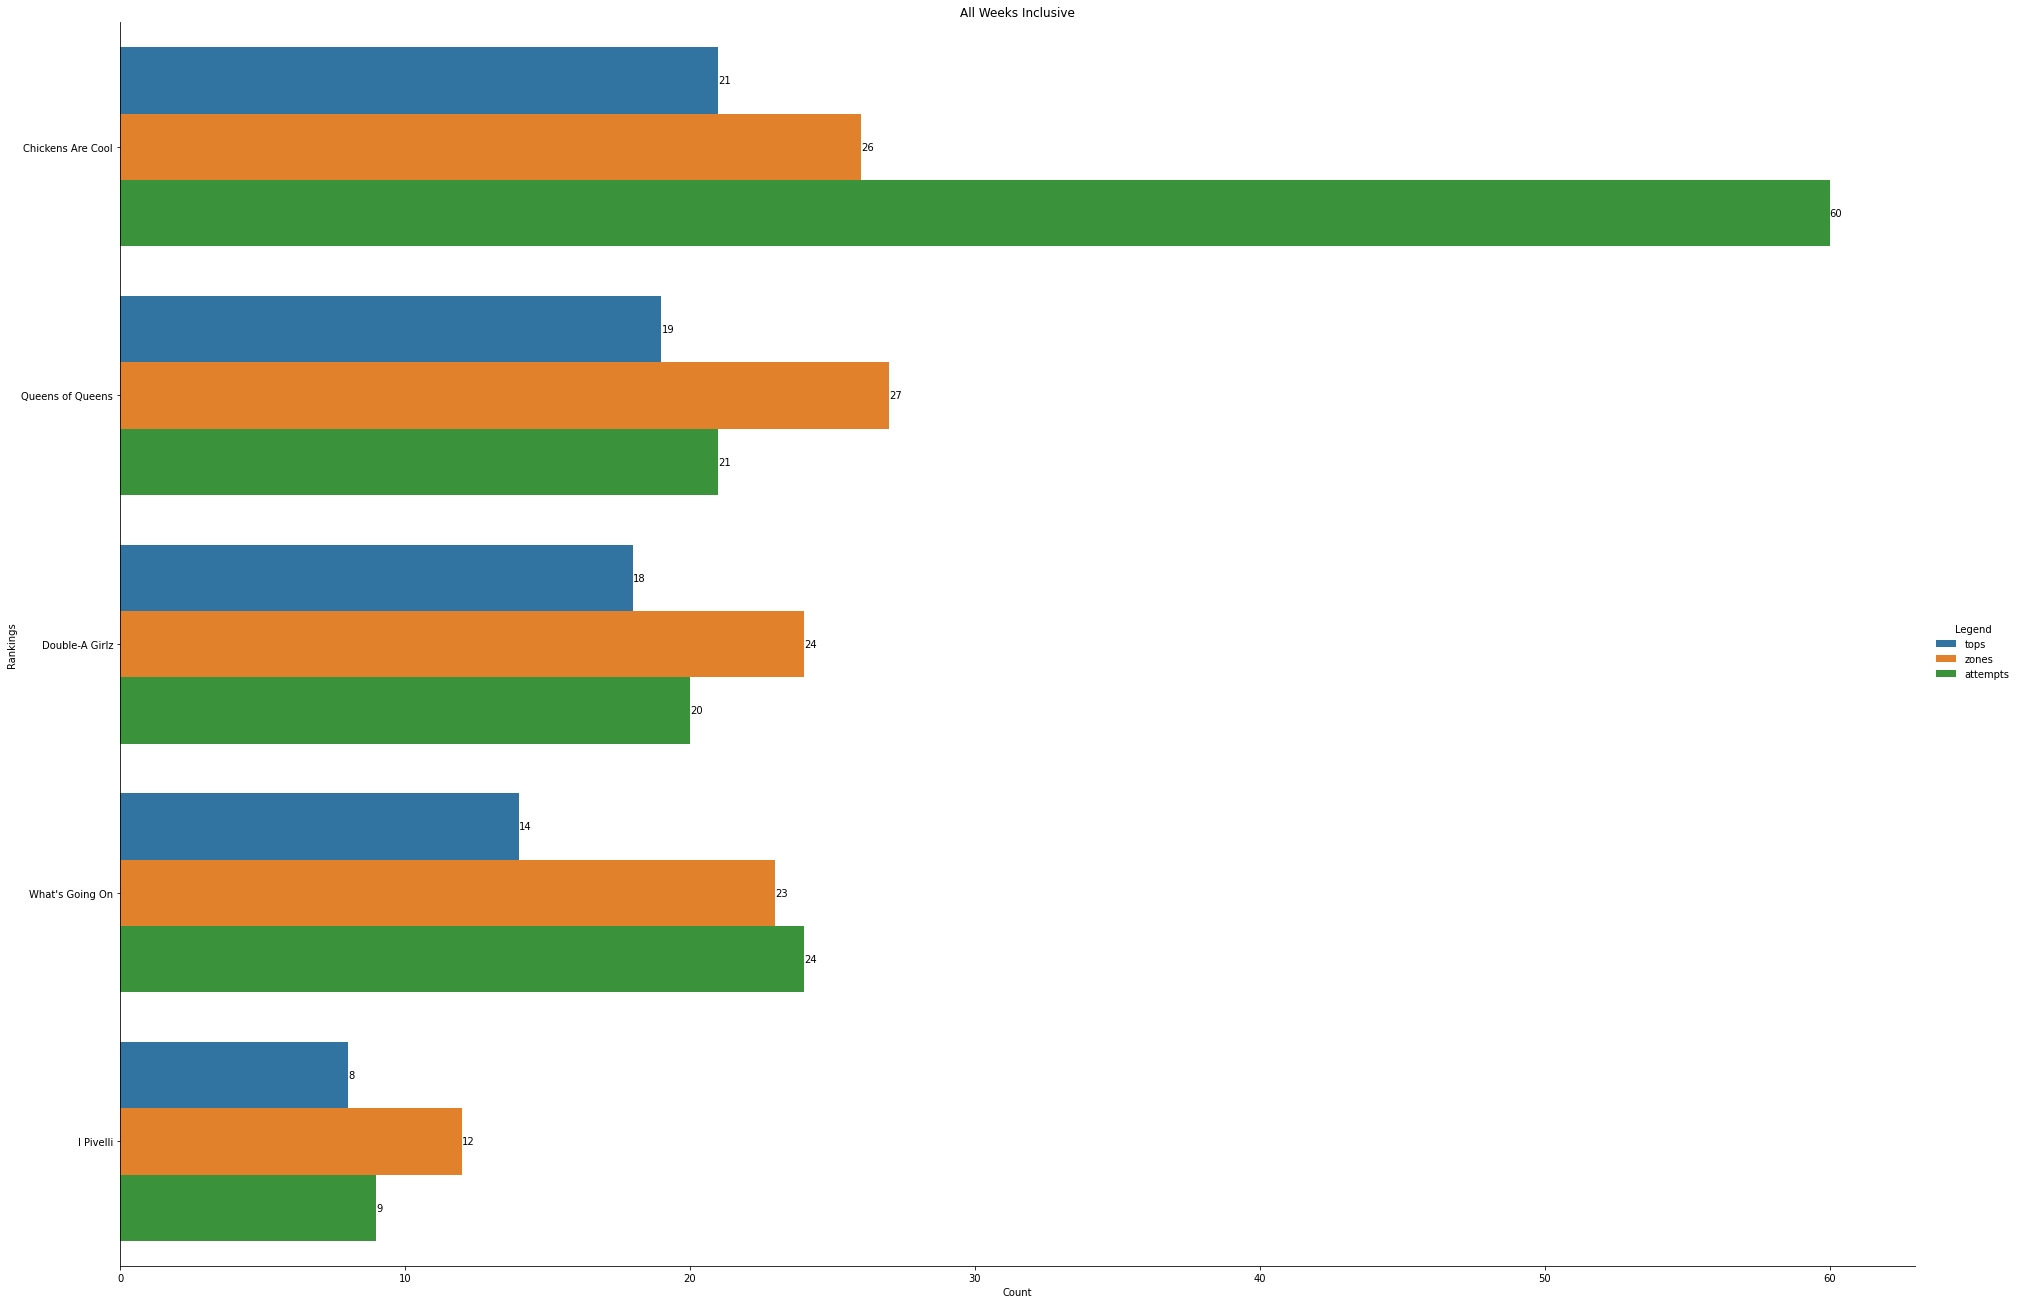

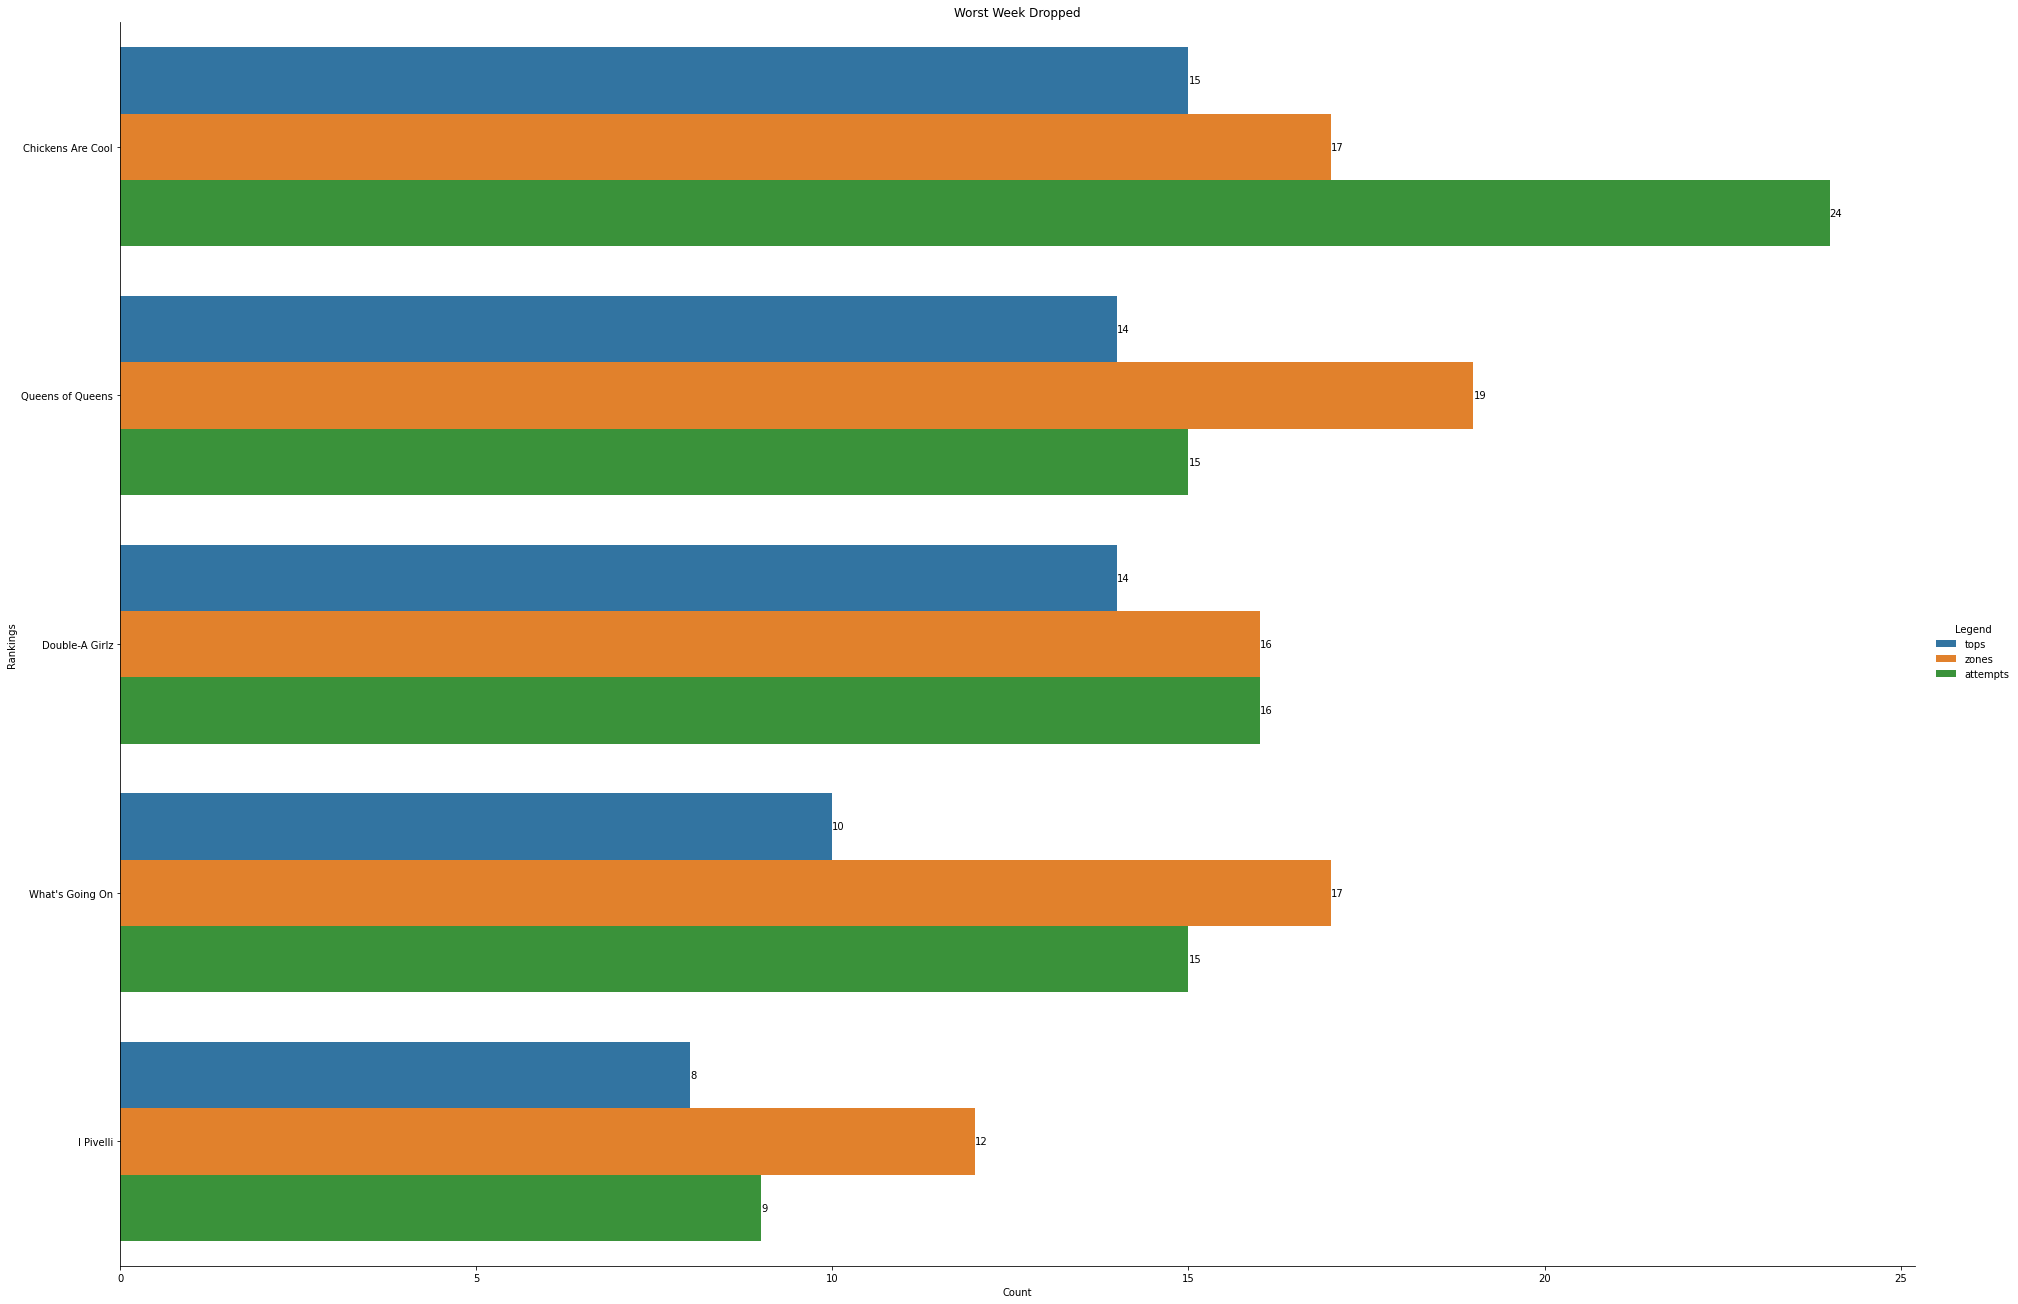

In [11]:
recreational_team_results_overall = prepare_team_results("recreational", "overall")
recreational_team_results_adjusted = prepare_team_results("recreational", "adjusted")

display(recreational_team_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(recreational_team_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

recreational_team_results_overall = recreational_team_results_overall.drop(["rank"], axis=1)
recreational_team_results_adjusted = recreational_team_results_adjusted.drop(["rank"], axis=1)

plot_results(recreational_team_results_overall, "All Weeks Inclusive")
plot_results(recreational_team_results_adjusted, "Worst Week Dropped")

### Individual Results: Recreational

,rank,tops,zones,attempts,worst_week
name,,,,,
Tyler Beckinham,1,15,15,50,"{""tops"": 5, ""zones"": 5, ""attempts"": 35}"
Kate Polinsky,2,11,15,12,"{""tops"": 3, ""zones"": 5, ""attempts"": 4}"
Ava Oertle,3,9,12,9,"{""tops"": 2, ""zones"": 4, ""attempts"": 2}"
Alyssa Macaluso,4,9,12,11,"{""tops"": 2, ""zones"": 4, ""attempts"": 2}"
Armel Dogruluk,5,8,12,9,"{""tops"": 2, ""zones"": 3, ""attempts"": 2}"
Amalia Aquino,6,7,13,11,"{""tops"": 2, ""zones"": 4, ""attempts"": 3}"
Sadmanul Islam,7,7,10,13,"{""tops"": 2, ""zones"": 2, ""attempts"": 6}"
Riley Synan,8,6,11,10,"{""tops"": 1, ""zones"": 4, ""attempts"": 1}"
Nicola de Prisco,9,6,8,7,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"


,rank,tops,zones,attempts,worst_week
name,,,,,
Tyler Beckinham,1,10,10,15,"{""tops"": 5, ""zones"": 5, ""attempts"": 35}"
Kate Polinsky,2,8,10,8,"{""tops"": 3, ""zones"": 5, ""attempts"": 4}"
Ava Oertle,3,7,8,7,"{""tops"": 2, ""zones"": 4, ""attempts"": 2}"
Alyssa Macaluso,4,7,8,9,"{""tops"": 2, ""zones"": 4, ""attempts"": 2}"
Armel Dogruluk,5,6,9,7,"{""tops"": 2, ""zones"": 3, ""attempts"": 2}"
Nicola de Prisco,6,6,8,7,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"
Amalia Aquino,7,5,9,8,"{""tops"": 2, ""zones"": 4, ""attempts"": 3}"
Sadmanul Islam,8,5,8,7,"{""tops"": 2, ""zones"": 2, ""attempts"": 6}"
Riley Synan,9,5,7,9,"{""tops"": 1, ""zones"": 4, ""attempts"": 1}"


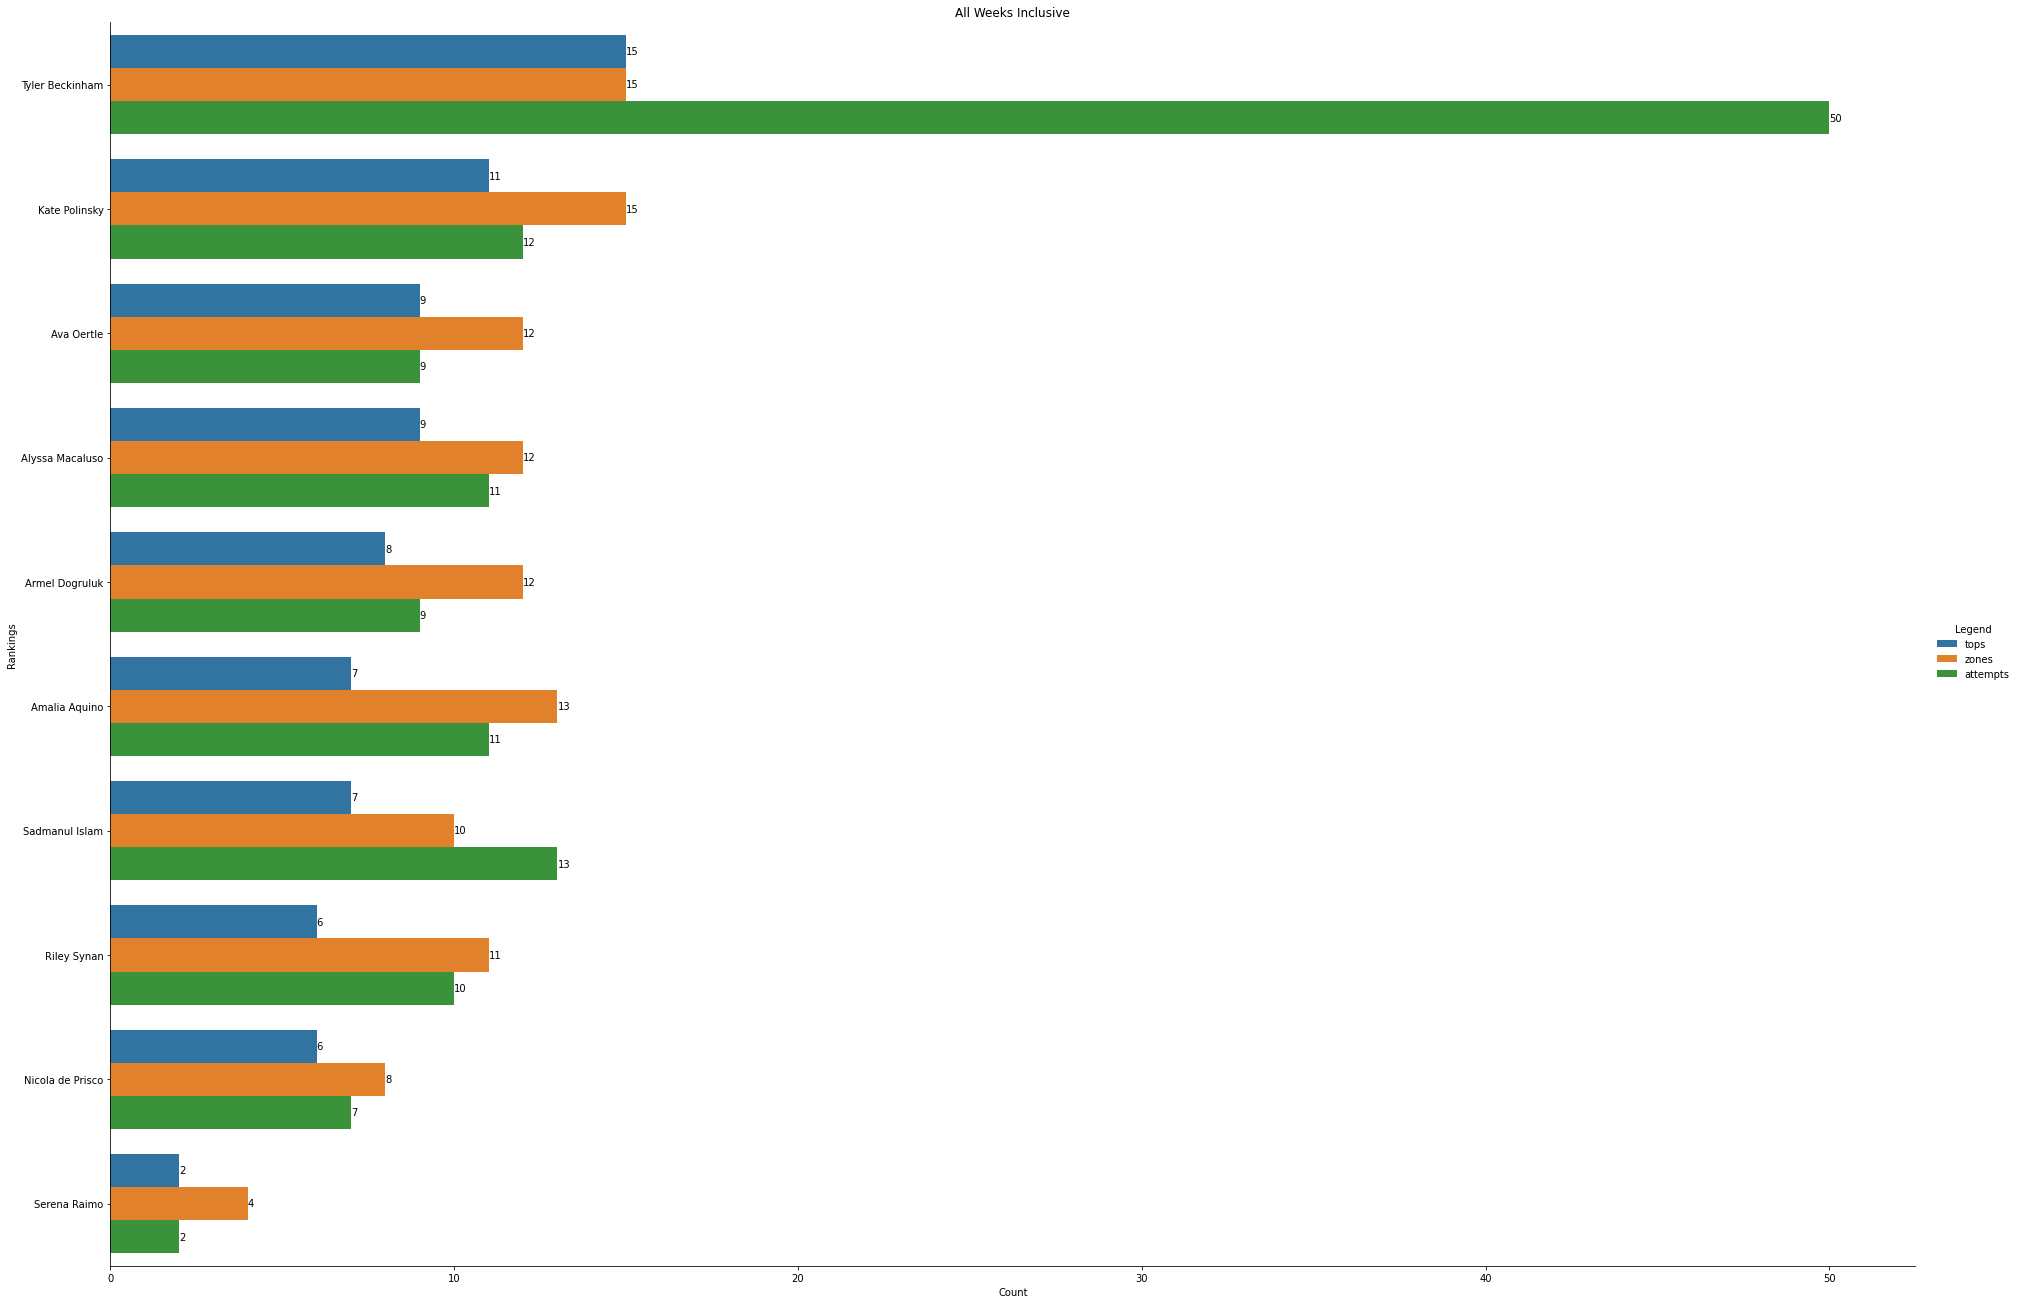

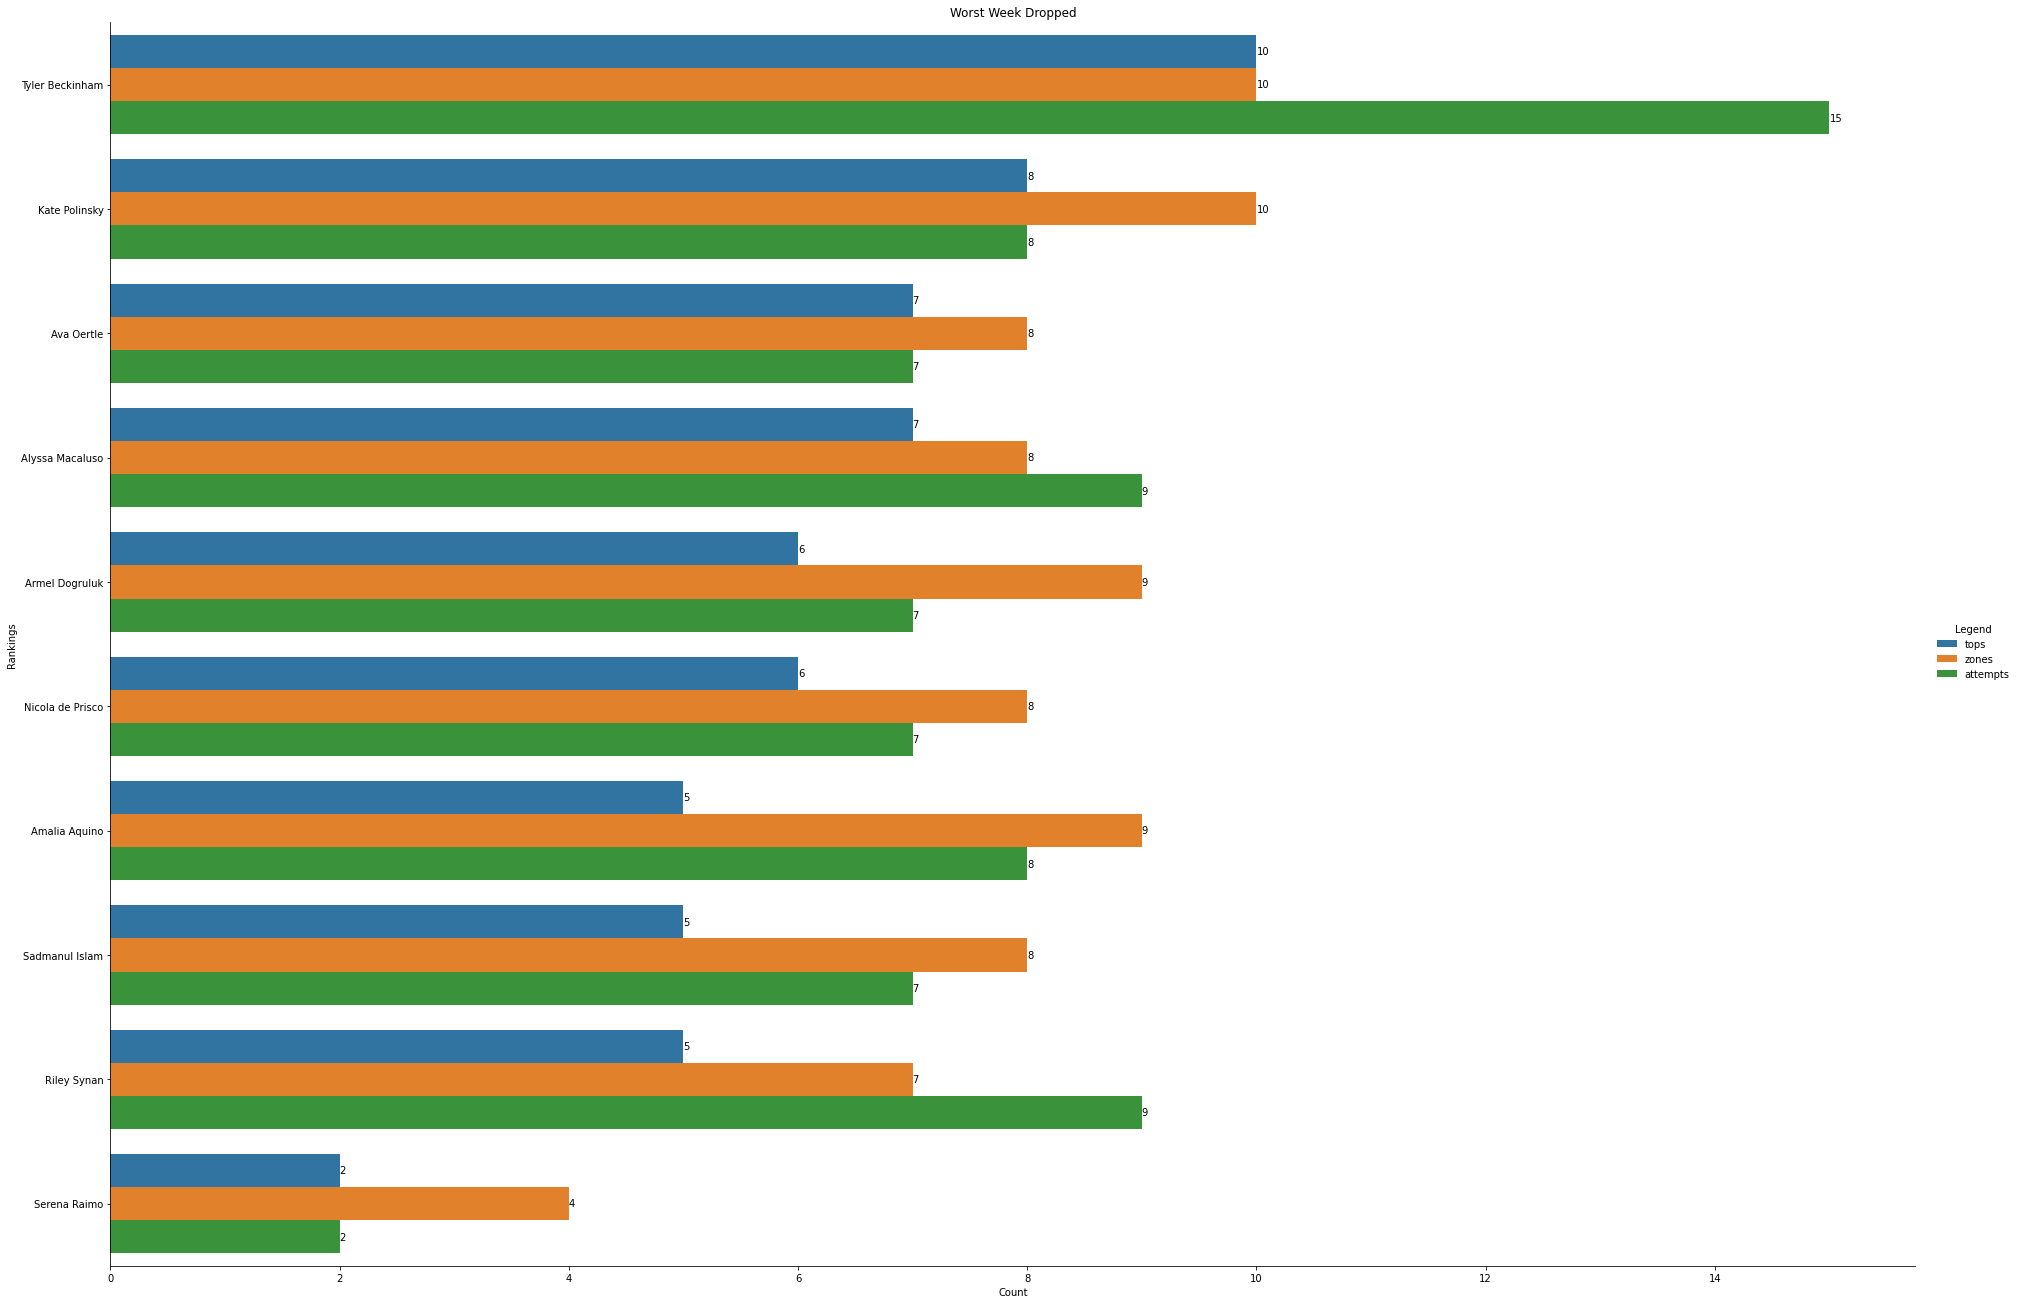

In [12]:
recreational_results_overall = prepare_results("recreational", "overall")
recreational_results_adjusted = prepare_results("recreational", "adjusted")

display(recreational_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(recreational_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

recreational_results_overall = recreational_results_overall.drop(["rank", "worst_week"], axis=1)
recreational_results_adjusted = recreational_results_adjusted.drop(["rank", "worst_week"], axis=1)

plot_results(recreational_results_overall, "All Weeks Inclusive")
plot_results(recreational_results_adjusted, "Worst Week Dropped")

## Progression Results

### Advanced Category

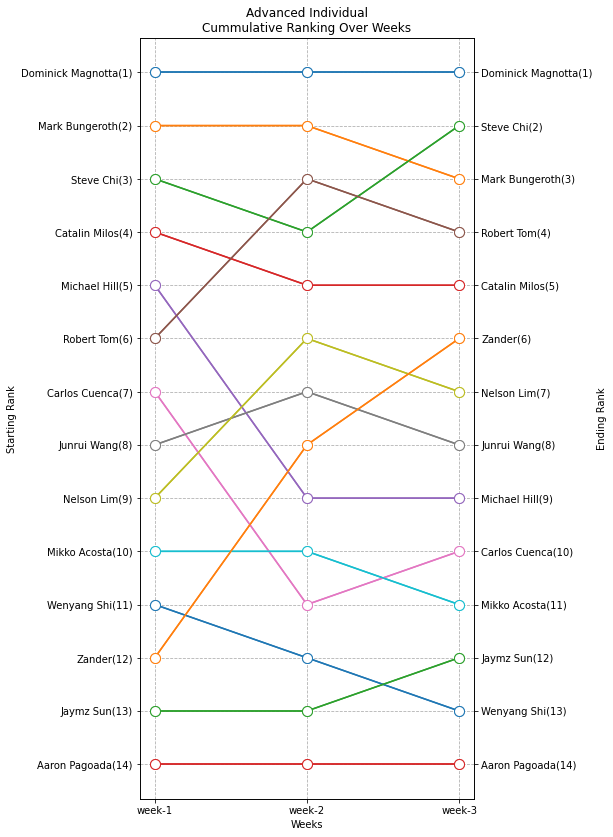

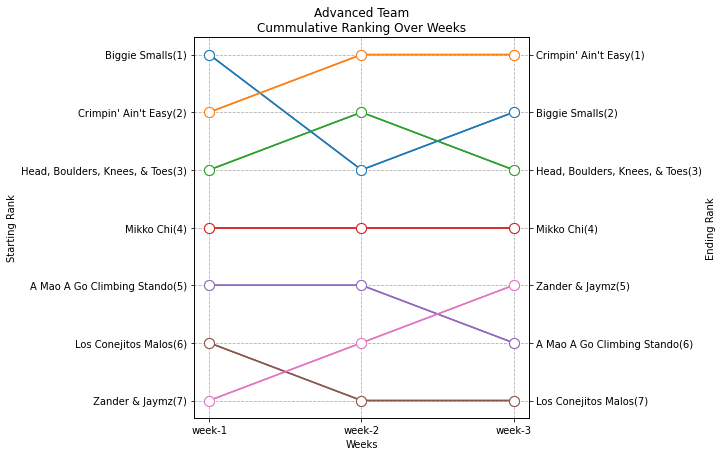

In [13]:
plot_rank_progression(weekly_ranks_cummulative("advanced"), "Advanced Individual\nCummulative Ranking Over Weeks")
plot_rank_progression(team_weekly_ranks_cummulative("advanced"), "Advanced Team\nCummulative Ranking Over Weeks")


### Intermediate Category

week-1 {'name': 'Team Oreo', 'tops': 14, 'zones': 17, 'attempts': 23}
week-2 {'name': 'Team Oreo', 'tops': 25, 'zones': 34, 'attempts': 34}
week-3 {'name': 'Team Oreo', 'tops': 39, 'zones': 52, 'attempts': 65}


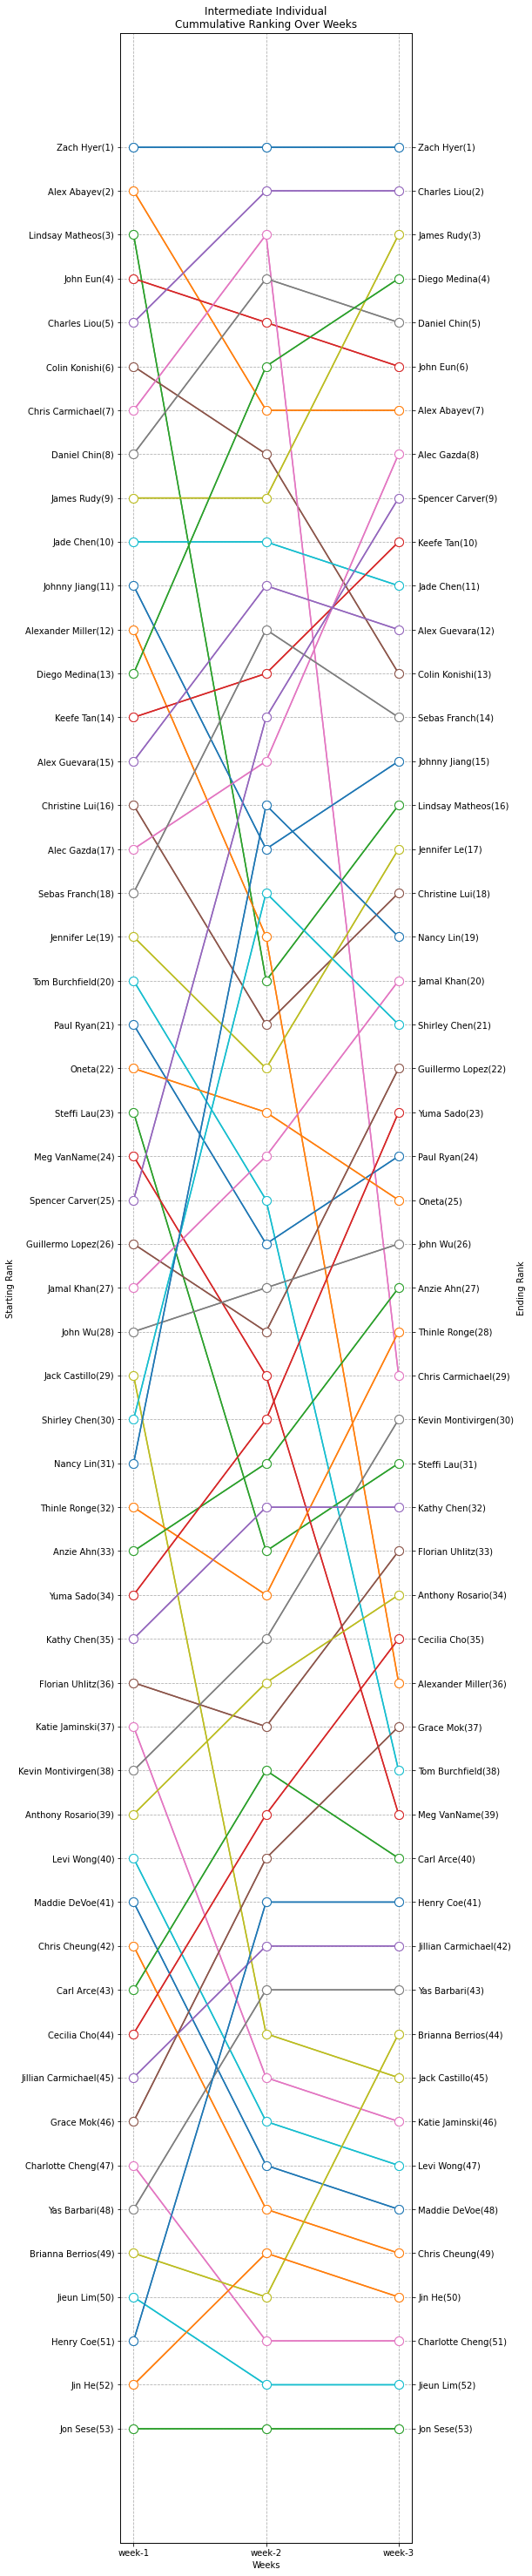

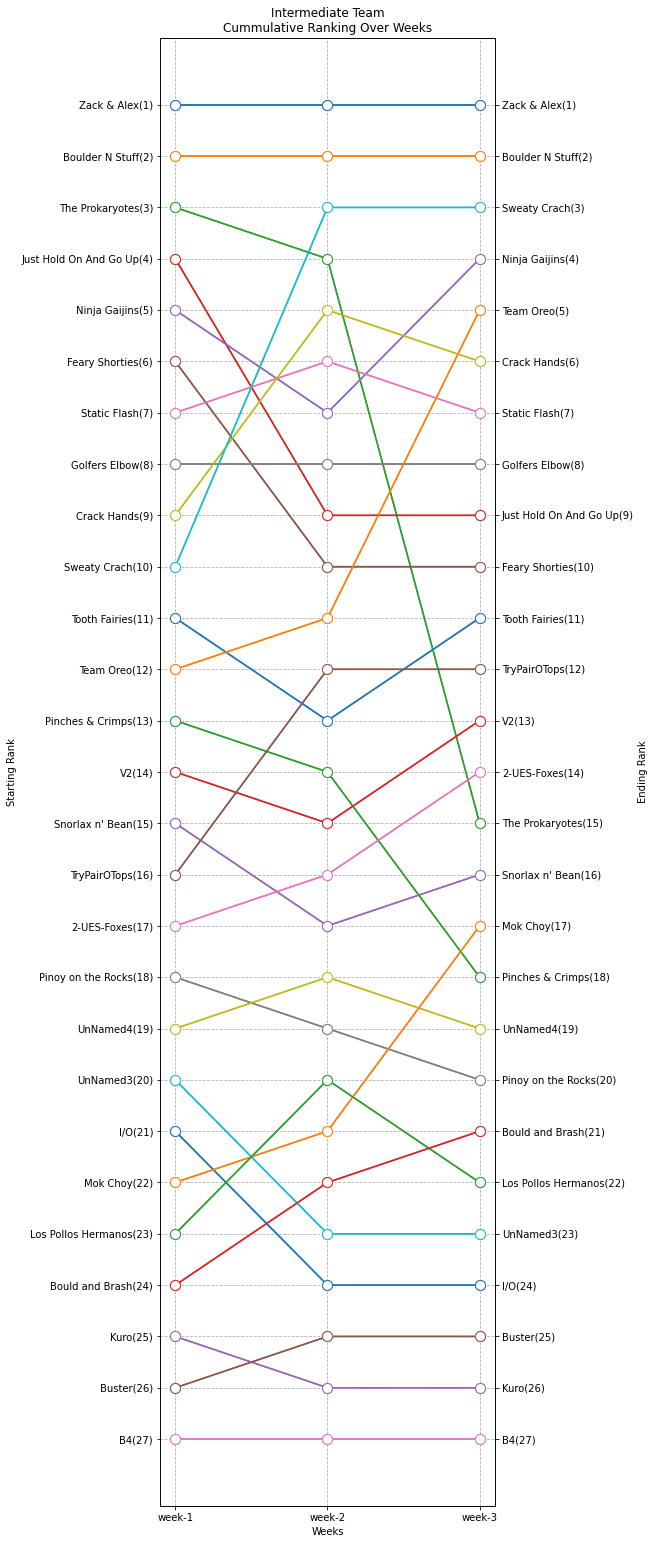

In [14]:
plot_rank_progression(weekly_ranks_cummulative("intermediate"), "Intermediate Individual\nCummulative Ranking Over Weeks")
plot_rank_progression(team_weekly_ranks_cummulative("intermediate"), "Intermediate Team\nCummulative Ranking Over Weeks")

### Recreational Category

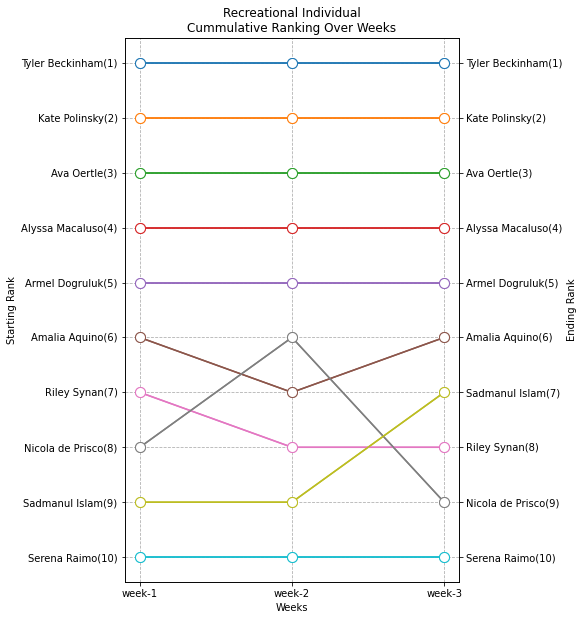

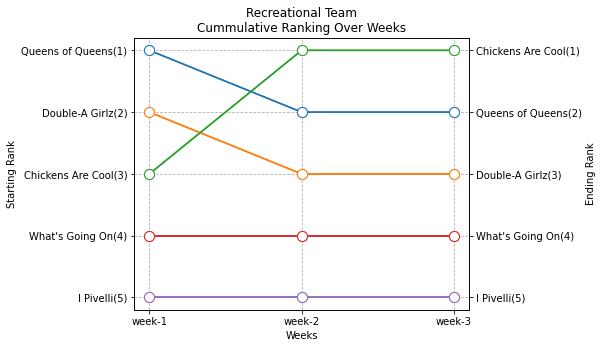

In [15]:
plot_rank_progression(weekly_ranks_cummulative("recreational"), "Recreational Individual\nCummulative Ranking Over Weeks")
plot_rank_progression(team_weekly_ranks_cummulative("recreational"), "Recreational Team\nCummulative Ranking Over Weeks")